In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Reshape, Dropout, LeakyReLU, Conv1D, Lambda
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.initializers import Zeros
import pickle
import itertools
import random


data0 = pd.read_csv("data/data_0.csv")
data1 = pd.read_csv("data/data_1.csv")
data2 = pd.read_csv("data/data_2.csv")

VARIABLES_TO_FORECAST = [
    "non_shiftable_load",
    "dhw_demand",
    "cooling_demand",
    "solar_generation",
    "carbon_intensity",
]

LOOKBACK = 48
OUT_STEPS = 48  # the number of hours we want to predict
model_name = "NN"

USE_VAE = False
USE_PCA = False

TRESHOLD_BEST_FEATURES = {f: 0.2 for f in VARIABLES_TO_FORECAST}
TRESHOLD_BEST_FEATURES["cooling_demand"] = 0.15

# src_data = pd.concat([data0.iloc[:577], data1.iloc[:577], data2.iloc[:577]], ignore_index=True)
src_data = data0
columns_to_keep = {}

In [26]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.models import Model
import pandas as pd

from tqdm.keras import TqdmCallback

tf.keras.utils.set_random_seed(42)

VARIABLES_TO_FORECAST = [
    "non_shiftable_load",
    "dhw_demand",
    "cooling_demand",
    "solar_generation",
    "carbon_intensity",
]


def sampling(args):
    import keras.backend as K

    z_mean, z_log_sigma, latent_dim = args
    epsilon = K.random_normal(
        shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0
    )
    return z_mean + K.exp(z_log_sigma) * epsilon


class VAE2:
    def __init__(
        self,
        encoder_path=None,
        base_dir="my_models/models",
        act="swish",
        init="glorot_uniform",
    ):
        self.act = act
        self.init = init
        self.encoder = encoder_path
        self.base_dir = base_dir

    def build_autoencoder(self, dims, act=None, init=None):
        """
        Fully connected auto-encoder model, symmetric.
        Arguments:
            dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
                The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
            act: activation, not applied to Input, Hidden and Output layers
        return:
            (ae_model, encoder_model), Model of autoencoder and model of encoder
        """
        if act is None:
            act = self.act

        if init is None:
            init = self.init

        n_stacks = len(dims) - 1
        # input
        inputs = Input(shape=(dims[0],), name="input")
        x = inputs
        # internal layers in encoder
        for i in range(n_stacks - 1):
            x = Dense(
                dims[i + 1],
                activation=act,
                kernel_initializer=init,
                name="encoder_%d" % i,
            )(x)

        # hidden layer
        # encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here
        # --- Custom Latent Space Layer
        z_mean = Dense(units=dims[-1], name="Z-Mean")(x)  # Mean component
        z_log_sigma = Dense(units=dims[-1], name="Z-Log-Sigma")(
            x
        )  # Standard deviation component
        z = Lambda(sampling, name="Z-Sampling-Layer")(
            [z_mean, z_log_sigma, dims[-1]]
        )  # Z sampling layer

        latent_inputs = Input(shape=(dims[-1],), name="Input-Z-Sampling")
        x = latent_inputs
        # internal layers in decoder
        for i in range(n_stacks - 1, 0, -1):
            x = Dense(
                dims[i], activation=act, kernel_initializer=init, name="decoder_%d" % i
            )(x)

        # --- Output Layer Decoder
        outputs = Dense(dims[0], activation="linear", name="output")(x)

        # Instantiate a VAE model
        encoder = Model(inputs, [z_mean, z_log_sigma, z], name="Encoder-Model")
        decoder = Model(latent_inputs, outputs, name="Decoder-Model")

        # Define outputs from a VAE model by specifying how the encoder-decoder models are linked
        output_vae = decoder(
            encoder(inputs)[2]
        )  # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]

        vae = Model(inputs=inputs, outputs=output_vae, name="VAE")

        # Reconstruction loss compares inputs and outputs and tries to minimise the difference
        r_loss = dims[0] * keras.losses.mse(inputs, output_vae)  # use MSE

        # KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
        kl_loss = -0.5 * K.sum(
            1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=1
        )

        # The VAE loss is a combination of reconstruction loss and KL loss
        vae_loss = K.mean(r_loss + kl_loss)

        # Add loss to the model and compile it
        vae.add_loss(vae_loss)
        vae.compile(optimizer="adam")

        return vae, encoder

    def apply(self, df, to_forecast, out_steps, latent_dim=5, train_again=False):
        columns_to_keep = [
            f"{to_forecast}_future{i}" for i in range(1, out_steps + 1)
        ] + ["hour", "day_type"]

        df_keep = df[columns_to_keep]
        df_reduce = df.drop(columns_to_keep, axis=1)

        if self.encoder is None or train_again:
            print("-> Training encoder...")
            xs = df_reduce
            dims = [xs.shape[-1], 64, 32, latent_dim]
            autoencoder, encoder = self.build_autoencoder(dims)
            autoencoder.fit(
                xs,
                xs,
                batch_size=64,
                epochs=2000,
                verbose=0,
                callbacks=[
                    TqdmCallback(verbose=0),
                    EarlyStopping(monitor="loss", patience=10, verbose=0),
                ],
            )
            encoder.save(f"{self.base_dir}/encoder_{to_forecast}.keras")
        else:
            print("-> Loading encoder from: {}".format(self.encoder))
            encoder = tf.keras.models.load_model(self.encoder, safe_mode=False)
            xs = df_reduce

        reduced_df = pd.DataFrame(
            encoder.predict(xs)[-1],
            columns=["Z{}".format(i) for i in range(latent_dim)],
        )
        return pd.concat([df_keep, reduced_df], axis=1)

In [27]:
def plot_history(history, to_forecast):
    plt.figure(figsize=(7, 5))
    plt.plot(history.history["loss"], label="train")
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"], label="test")
    plt.legend()
    plt.show()
    # plt.savefig(f'images/loss_curves/{model_name}_{to_forecast}.png')

In [28]:
def plot_residuals_distribution(y_true, y_pred, to_forecast):
    errors = y_pred - y_true
    errors_plot = errors[
        [
            f"{to_forecast}_future1",
            f"{to_forecast}_future10",
            f"{to_forecast}_future20",
            f"{to_forecast}_future30",
            f"{to_forecast}_future40",
        ]
    ]
    errors_plot = np.abs(errors_plot)

    # rename columns for plotting
    errors_plot.columns = ["1h", "10h", "20h", "30h", "40h"]

    sns.violinplot(errors_plot)  # , hue="alive")
    plt.show()
    return errors

In [29]:
def run(OUT_STEPS, to_forecast):
    data = data0[: 577 + OUT_STEPS].copy()

    data[data["non_shiftable_load"] > 2.3] = 0

    # create lag features with pd.shift
    columns = data.columns

    for i in range(1, LOOKBACK):
        for f in columns:
            data[f"{f}_lag{i}"] = data[f].shift(i).values

    # create yhat for the next 48 hours
    for i in range(1, OUT_STEPS + 1):
        data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values

    # drop rows with NaN values
    data.dropna(inplace=True)

    data.index = pd.RangeIndex(len(data.index))

    scaler = StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

    data.shape

    vae = VAE2(base_dir="models")

    data2 = vae.apply(
        data, to_forecast, latent_dim=5, train_again=True, out_steps=OUT_STEPS
    )

    X = data2.drop(
        [f"{to_forecast}_future{i}" for i in range(1, OUT_STEPS + 1)], axis=1
    )
    Y = data2[[f"{to_forecast}_future{i}" for i in range(1, OUT_STEPS + 1)]]

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.3, shuffle=False, random_state=42
    )

    # # dense model
    model = Sequential(
        [
            Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
            Dropout(0.35),
            Dense(32, activation="relu"),
            Dropout(0.3),
            Dense(OUT_STEPS, activation="linear"),
        ]
    )

    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            min_delta=0.00001,
            patience=10,
            mode="auto",
            restore_best_weights=True,
        )
    ]

    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    history = model.fit(
        X_train,
        Y_train,
        epochs=200,
        verbose=1,
        validation_data=(X_test, Y_test),
        callbacks=callbacks,
    )
    model.save(f"models/{model_name}_{to_forecast}.keras")

    # plot_history(history, to_forecast)

    # model = load_model(f'my_models/models/{model_name}_{to_forecast}.keras')

    mse = model.evaluate(X_test, Y_test, verbose=0)[0]
    print(f"{to_forecast} MSE: {mse}")

    return mse

FORECASTING: non_shiftable_load
OUT_STEPS: 1


/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 196/2000 [00:12<01:58, 15.25epoch/s, loss=554]


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 1.3188 - mae: 0.7137 - val_loss: 1.0313 - val_mae: 0.5881
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1062 - mae: 0.6795 - val_loss: 0.9657 - val_mae: 0.5797
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1909 - mae: 0.6828 - val_loss: 0.9395 - val_mae: 0.5638
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0121 - mae: 0.6096 - val_loss: 0.9285 - val_mae: 0.5511
Epoch 5/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0016 - mae: 0.6059 - val_loss: 0.9222 - val_mae: 0.5409
Epoch 6/200
12/12 [==============================] - 0s 11ms/step - loss: 0.9533 - mae: 0.5749 - val_loss: 0.9188 - val_mae: 0.5366
Epoch 7/200
12/12 [==============================] - 0s 8ms/step - loss: 0.9952 - mae: 0.5914 - val_loss: 0.9137 - val_mae: 0.5372
Epoch 8/200
12/12 [=========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:11<01:46, 17.00epoch/s, loss=557]  


17/17 [==============================] - 0s 1ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.5596 - mae: 0.8562 - val_loss: 1.0164 - val_mae: 0.6171
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2634 - mae: 0.7397 - val_loss: 0.9648 - val_mae: 0.5872
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.1997 - mae: 0.6943 - val_loss: 0.9391 - val_mae: 0.5659
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.1796 - mae: 0.6786 - val_loss: 0.9239 - val_mae: 0.5510
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0729 - mae: 0.6311 - val_loss: 0.9148 - val_mae: 0.5445
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 1.0502 - mae: 0.6142 - val_loss: 0.9092 - val_mae: 0.5399
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0321 - mae: 0.6010 - val_loss: 0.9050 - val_mae: 0.5350
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:12<01:58, 15.25epoch/s, loss=559]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 22ms/step - loss: 1.3620 - mae: 0.7732 - val_loss: 1.0416 - val_mae: 0.6043
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.1985 - mae: 0.6767 - val_loss: 0.9957 - val_mae: 0.5692
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.1300 - mae: 0.6389 - val_loss: 0.9755 - val_mae: 0.5583
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0721 - mae: 0.6074 - val_loss: 0.9655 - val_mae: 0.5537
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 1.0570 - mae: 0.5942 - val_loss: 0.9602 - val_mae: 0.5517
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0379 - mae: 0.5843 - val_loss: 0.9564 - val_mae: 0.5498
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0181 - mae: 0.5743 - val_loss: 0.9537 - val_mae: 0.5491
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 196/2000 [00:13<02:01, 14.86epoch/s, loss=545]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 1.3445 - mae: 0.7517 - val_loss: 1.0863 - val_mae: 0.6385
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.1473 - mae: 0.6641 - val_loss: 1.0371 - val_mae: 0.6106
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0730 - mae: 0.6222 - val_loss: 1.0181 - val_mae: 0.5993
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0453 - mae: 0.6036 - val_loss: 1.0080 - val_mae: 0.5930
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0188 - mae: 0.5851 - val_loss: 1.0030 - val_mae: 0.5912
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0166 - mae: 0.5868 - val_loss: 0.9980 - val_mae: 0.5886
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0018 - mae: 0.5754 - val_loss: 0.9946 - val_mae: 0.5865
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:13<02:09, 13.97epoch/s, loss=549]    


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 1.3554 - mae: 0.7563 - val_loss: 1.1463 - val_mae: 0.6553
Epoch 2/200
12/12 [==============================] - 0s 14ms/step - loss: 1.1831 - mae: 0.6698 - val_loss: 1.0812 - val_mae: 0.6207
Epoch 3/200
12/12 [==============================] - 0s 18ms/step - loss: 1.0942 - mae: 0.6291 - val_loss: 1.0509 - val_mae: 0.6036
Epoch 4/200
12/12 [==============================] - 0s 11ms/step - loss: 1.0527 - mae: 0.6032 - val_loss: 1.0350 - val_mae: 0.5951
Epoch 5/200
12/12 [==============================] - 0s 15ms/step - loss: 1.0391 - mae: 0.5922 - val_loss: 1.0249 - val_mae: 0.5897
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0162 - mae: 0.5776 - val_loss: 1.0191 - val_mae: 0.5872
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9915 - mae: 0.5676 - val_loss: 1.0153 - val_mae: 0.5850
Epoch 8/200
12/12 [======

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:09<02:36, 12.03epoch/s, loss=600]    


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 17ms/step - loss: 1.3553 - mae: 0.7696 - val_loss: 1.1366 - val_mae: 0.6388
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1867 - mae: 0.6759 - val_loss: 1.0719 - val_mae: 0.6045
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1016 - mae: 0.6326 - val_loss: 1.0457 - val_mae: 0.5950
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0454 - mae: 0.6055 - val_loss: 1.0324 - val_mae: 0.5901
Epoch 5/200
12/12 [==============================] - 0s 22ms/step - loss: 1.0291 - mae: 0.5908 - val_loss: 1.0244 - val_mae: 0.5866
Epoch 6/200
12/12 [==============================] - 0s 12ms/step - loss: 1.0155 - mae: 0.5838 - val_loss: 1.0199 - val_mae: 0.5839
Epoch 7/200
12/12 [==============================] - 0s 30ms/step - loss: 1.0121 - mae: 0.5796 - val_loss: 1.0176 - val_mae: 0.5823
Epoch 8/200
12/12 [=======

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 11%|█         | 215/2000 [00:19<02:37, 11.30epoch/s, loss=546]    


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 20ms/step - loss: 1.2812 - mae: 0.7362 - val_loss: 1.1075 - val_mae: 0.6573
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.1154 - mae: 0.6497 - val_loss: 1.0588 - val_mae: 0.6237
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0553 - mae: 0.6120 - val_loss: 1.0388 - val_mae: 0.6070
Epoch 4/200
12/12 [==============================] - 0s 11ms/step - loss: 1.0294 - mae: 0.5943 - val_loss: 1.0301 - val_mae: 0.5980
Epoch 5/200
12/12 [==============================] - 0s 11ms/step - loss: 1.0046 - mae: 0.5792 - val_loss: 1.0251 - val_mae: 0.5924
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9987 - mae: 0.5725 - val_loss: 1.0218 - val_mae: 0.5888
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9984 - mae: 0.5716 - val_loss: 1.0193 - val_mae: 0.5857
Epoch 8/200
12/12 [========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 196/2000 [00:13<02:08, 14.07epoch/s, loss=548]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.2460 - mae: 0.7274 - val_loss: 1.1073 - val_mae: 0.6438
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1290 - mae: 0.6536 - val_loss: 1.0642 - val_mae: 0.6171
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0597 - mae: 0.6157 - val_loss: 1.0476 - val_mae: 0.6058
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0322 - mae: 0.5962 - val_loss: 1.0382 - val_mae: 0.5986
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0116 - mae: 0.5831 - val_loss: 1.0327 - val_mae: 0.5946
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0046 - mae: 0.5791 - val_loss: 1.0289 - val_mae: 0.5920
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9947 - mae: 0.5720 - val_loss: 1.0266 - val_mae: 0.5892
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:10<02:07, 14.60epoch/s, loss=582]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 2s 36ms/step - loss: 1.2928 - mae: 0.7326 - val_loss: 1.1353 - val_mae: 0.6505
Epoch 2/200
12/12 [==============================] - 0s 9ms/step - loss: 1.1547 - mae: 0.6637 - val_loss: 1.0807 - val_mae: 0.6214
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0756 - mae: 0.6241 - val_loss: 1.0571 - val_mae: 0.6090
Epoch 4/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0475 - mae: 0.6047 - val_loss: 1.0448 - val_mae: 0.6030
Epoch 5/200
12/12 [==============================] - 0s 12ms/step - loss: 1.0219 - mae: 0.5917 - val_loss: 1.0375 - val_mae: 0.5992
Epoch 6/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0147 - mae: 0.5855 - val_loss: 1.0334 - val_mae: 0.5971
Epoch 7/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0009 - mae: 0.5769 - val_loss: 1.0310 - val_mae: 0.5956
Epoch 8/200
12/12 [=========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:09<01:54, 16.18epoch/s, loss=572]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 14ms/step - loss: 1.2707 - mae: 0.7315 - val_loss: 1.1143 - val_mae: 0.6362
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.1306 - mae: 0.6535 - val_loss: 1.0677 - val_mae: 0.6127
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0649 - mae: 0.6165 - val_loss: 1.0477 - val_mae: 0.6040
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0315 - mae: 0.5976 - val_loss: 1.0395 - val_mae: 0.6013
Epoch 5/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0205 - mae: 0.5888 - val_loss: 1.0355 - val_mae: 0.6000
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0107 - mae: 0.5817 - val_loss: 1.0336 - val_mae: 0.5995
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0074 - mae: 0.5797 - val_loss: 1.0323 - val_mae: 0.5992
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 196/2000 [00:09<01:26, 20.91epoch/s, loss=547]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 21ms/step - loss: 1.2317 - mae: 0.6961 - val_loss: 1.0867 - val_mae: 0.6132
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1167 - mae: 0.6331 - val_loss: 1.0524 - val_mae: 0.6012
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0552 - mae: 0.6062 - val_loss: 1.0388 - val_mae: 0.5982
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0267 - mae: 0.5904 - val_loss: 1.0322 - val_mae: 0.5971
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0167 - mae: 0.5851 - val_loss: 1.0286 - val_mae: 0.5966
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0070 - mae: 0.5771 - val_loss: 1.0268 - val_mae: 0.5967
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9985 - mae: 0.5741 - val_loss: 1.0259 - val_mae: 0.5967
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:12<02:33, 12.12epoch/s, loss=573]    


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 1.1807 - mae: 0.6787 - val_loss: 1.0628 - val_mae: 0.6055
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0743 - mae: 0.6207 - val_loss: 1.0355 - val_mae: 0.5930
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0361 - mae: 0.5959 - val_loss: 1.0258 - val_mae: 0.5907
Epoch 4/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0207 - mae: 0.5852 - val_loss: 1.0219 - val_mae: 0.5908
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0049 - mae: 0.5784 - val_loss: 1.0202 - val_mae: 0.5910
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0011 - mae: 0.5757 - val_loss: 1.0190 - val_mae: 0.5910
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9963 - mae: 0.5718 - val_loss: 1.0181 - val_mae: 0.5908
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:12<02:00, 15.00epoch/s, loss=563]    


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 19ms/step - loss: 1.2013 - mae: 0.6917 - val_loss: 1.0546 - val_mae: 0.6169
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0848 - mae: 0.6264 - val_loss: 1.0250 - val_mae: 0.5976
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0402 - mae: 0.5962 - val_loss: 1.0136 - val_mae: 0.5910
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0228 - mae: 0.5850 - val_loss: 1.0079 - val_mae: 0.5880
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0145 - mae: 0.5808 - val_loss: 1.0046 - val_mae: 0.5864
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0095 - mae: 0.5757 - val_loss: 1.0026 - val_mae: 0.5851
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0000 - mae: 0.5715 - val_loss: 1.0012 - val_mae: 0.5842
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:11<01:43, 17.40epoch/s, loss=560]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1727 - mae: 0.6825 - val_loss: 1.0365 - val_mae: 0.6108
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0850 - mae: 0.6298 - val_loss: 1.0119 - val_mae: 0.5934
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0502 - mae: 0.6020 - val_loss: 1.0021 - val_mae: 0.5871
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0300 - mae: 0.5900 - val_loss: 0.9978 - val_mae: 0.5851
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0180 - mae: 0.5827 - val_loss: 0.9957 - val_mae: 0.5842
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0115 - mae: 0.5785 - val_loss: 0.9941 - val_mae: 0.5832
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0064 - mae: 0.5743 - val_loss: 0.9929 - val_mae: 0.5822
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:09<01:57, 15.84epoch/s, loss=580]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.2008 - mae: 0.6929 - val_loss: 1.0451 - val_mae: 0.6101
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0908 - mae: 0.6264 - val_loss: 1.0131 - val_mae: 0.5907
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0595 - mae: 0.6059 - val_loss: 1.0008 - val_mae: 0.5845
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0377 - mae: 0.5922 - val_loss: 0.9954 - val_mae: 0.5829
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0265 - mae: 0.5843 - val_loss: 0.9922 - val_mae: 0.5823
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0196 - mae: 0.5815 - val_loss: 0.9905 - val_mae: 0.5817
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0154 - mae: 0.5772 - val_loss: 0.9894 - val_mae: 0.5815
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  8%|▊         | 166/2000 [00:11<02:06, 14.44epoch/s, loss=567]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 24ms/step - loss: 1.2019 - mae: 0.6841 - val_loss: 1.0433 - val_mae: 0.5997
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0983 - mae: 0.6252 - val_loss: 1.0067 - val_mae: 0.5818
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0552 - mae: 0.6019 - val_loss: 0.9924 - val_mae: 0.5769
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0345 - mae: 0.5880 - val_loss: 0.9861 - val_mae: 0.5764
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0257 - mae: 0.5824 - val_loss: 0.9830 - val_mae: 0.5765
Epoch 6/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0163 - mae: 0.5776 - val_loss: 0.9813 - val_mae: 0.5767
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0112 - mae: 0.5738 - val_loss: 0.9802 - val_mae: 0.5768
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  9%|▉         | 186/2000 [00:13<02:07, 14.26epoch/s, loss=546]  


17/17 [==============================] - 0s 6ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1453 - mae: 0.6671 - val_loss: 1.0134 - val_mae: 0.6060
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0705 - mae: 0.6173 - val_loss: 0.9936 - val_mae: 0.5913
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 1.0435 - mae: 0.5994 - val_loss: 0.9865 - val_mae: 0.5861
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0249 - mae: 0.5872 - val_loss: 0.9841 - val_mae: 0.5845
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0171 - mae: 0.5825 - val_loss: 0.9831 - val_mae: 0.5836
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 1.0172 - mae: 0.5803 - val_loss: 0.9826 - val_mae: 0.5832
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0118 - mae: 0.5792 - val_loss: 0.9824 - val_mae: 0.5828
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:14<02:14, 13.44epoch/s, loss=557]  

17/17 [==============================] - 0s 2ms/step


Epoch 1/200
12/12 [==============================] - 1s 20ms/step - loss: 1.1460 - mae: 0.6513 - val_loss: 1.0193 - val_mae: 0.5942
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0734 - mae: 0.6127 - val_loss: 0.9959 - val_mae: 0.5846
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0375 - mae: 0.5928 - val_loss: 0.9873 - val_mae: 0.5820
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0275 - mae: 0.5861 - val_loss: 0.9834 - val_mae: 0.5813
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0145 - mae: 0.5793 - val_loss: 0.9814 - val_mae: 0.5806
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0110 - mae: 0.5776 - val_loss: 0.9802 - val_mae: 0.5800
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0084 - mae: 0.5759 - val_loss: 0.9792 - val_mae: 0.5792
Epoch 8/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0017 - 

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:17<02:40, 11.26epoch/s, loss=549]    


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 22ms/step - loss: 1.1339 - mae: 0.6512 - val_loss: 1.0173 - val_mae: 0.5926
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0656 - mae: 0.6104 - val_loss: 0.9972 - val_mae: 0.5836
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0321 - mae: 0.5906 - val_loss: 0.9900 - val_mae: 0.5820
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0210 - mae: 0.5848 - val_loss: 0.9870 - val_mae: 0.5821
Epoch 5/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0138 - mae: 0.5799 - val_loss: 0.9855 - val_mae: 0.5822
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0070 - mae: 0.5777 - val_loss: 0.9846 - val_mae: 0.5821
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0050 - mae: 0.5753 - val_loss: 0.9836 - val_mae: 0.5815
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:13<02:07, 14.12epoch/s, loss=557]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 33ms/step - loss: 1.1356 - mae: 0.6608 - val_loss: 1.0291 - val_mae: 0.6001
Epoch 2/200
12/12 [==============================] - 0s 27ms/step - loss: 1.0671 - mae: 0.6131 - val_loss: 1.0050 - val_mae: 0.5866
Epoch 3/200
12/12 [==============================] - 0s 26ms/step - loss: 1.0367 - mae: 0.5944 - val_loss: 0.9959 - val_mae: 0.5825
Epoch 4/200
12/12 [==============================] - 0s 31ms/step - loss: 1.0193 - mae: 0.5848 - val_loss: 0.9924 - val_mae: 0.5818
Epoch 5/200
12/12 [==============================] - 0s 28ms/step - loss: 1.0114 - mae: 0.5795 - val_loss: 0.9906 - val_mae: 0.5814
Epoch 6/200
12/12 [==============================] - 0s 24ms/step - loss: 1.0066 - mae: 0.5758 - val_loss: 0.9893 - val_mae: 0.5810
Epoch 7/200
12/12 [==============================] - 0s 22ms/step - loss: 1.0003 - mae: 0.5730 - val_loss: 0.9880 - val_mae: 0.5802
Epoch 8/200
12/12 [====

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:13<02:01, 14.90epoch/s, loss=553]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1539 - mae: 0.6621 - val_loss: 1.0426 - val_mae: 0.6067
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0785 - mae: 0.6174 - val_loss: 1.0174 - val_mae: 0.5938
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0414 - mae: 0.5966 - val_loss: 1.0071 - val_mae: 0.5897
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0248 - mae: 0.5869 - val_loss: 1.0023 - val_mae: 0.5881
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0176 - mae: 0.5821 - val_loss: 0.9996 - val_mae: 0.5872
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0109 - mae: 0.5792 - val_loss: 0.9979 - val_mae: 0.5867
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0055 - mae: 0.5762 - val_loss: 0.9967 - val_mae: 0.5861
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:13<02:08, 14.06epoch/s, loss=552]    


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 17ms/step - loss: 1.1669 - mae: 0.6718 - val_loss: 1.0642 - val_mae: 0.6217
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0798 - mae: 0.6228 - val_loss: 1.0279 - val_mae: 0.6014
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0481 - mae: 0.6020 - val_loss: 1.0135 - val_mae: 0.5946
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0269 - mae: 0.5897 - val_loss: 1.0067 - val_mae: 0.5915
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0152 - mae: 0.5846 - val_loss: 1.0030 - val_mae: 0.5899
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0074 - mae: 0.5798 - val_loss: 1.0009 - val_mae: 0.5887
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0047 - mae: 0.5776 - val_loss: 0.9991 - val_mae: 0.5874
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:12<01:59, 15.18epoch/s, loss=555]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1239 - mae: 0.6594 - val_loss: 1.0433 - val_mae: 0.6096
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0596 - mae: 0.6167 - val_loss: 1.0198 - val_mae: 0.5946
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0314 - mae: 0.5962 - val_loss: 1.0104 - val_mae: 0.5895
Epoch 4/200
12/12 [==============================] - 0s 10ms/step - loss: 1.0134 - mae: 0.5852 - val_loss: 1.0062 - val_mae: 0.5876
Epoch 5/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0057 - mae: 0.5794 - val_loss: 1.0040 - val_mae: 0.5865
Epoch 6/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0027 - mae: 0.5758 - val_loss: 1.0024 - val_mae: 0.5858
Epoch 7/200
12/12 [==============================] - 0s 9ms/step - loss: 0.9959 - mae: 0.5731 - val_loss: 1.0010 - val_mae: 0.5850
Epoch 8/200
12/12 [=========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  9%|▉         | 186/2000 [00:11<01:50, 16.43epoch/s, loss=550]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1016 - mae: 0.6384 - val_loss: 1.0435 - val_mae: 0.6028
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0365 - mae: 0.5992 - val_loss: 1.0268 - val_mae: 0.5962
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0160 - mae: 0.5863 - val_loss: 1.0206 - val_mae: 0.5952
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0071 - mae: 0.5815 - val_loss: 1.0177 - val_mae: 0.5952
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0007 - mae: 0.5784 - val_loss: 1.0163 - val_mae: 0.5955
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9961 - mae: 0.5760 - val_loss: 1.0153 - val_mae: 0.5956
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9940 - mae: 0.5752 - val_loss: 1.0146 - val_mae: 0.5954
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:10<01:40, 17.91epoch/s, loss=547]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 28ms/step - loss: 1.0781 - mae: 0.6290 - val_loss: 1.0419 - val_mae: 0.6057
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0327 - mae: 0.5996 - val_loss: 1.0309 - val_mae: 0.6003
Epoch 3/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0107 - mae: 0.5854 - val_loss: 1.0271 - val_mae: 0.5989
Epoch 4/200
12/12 [==============================] - 0s 12ms/step - loss: 1.0012 - mae: 0.5800 - val_loss: 1.0259 - val_mae: 0.5987
Epoch 5/200
12/12 [==============================] - 0s 8ms/step - loss: 0.9953 - mae: 0.5770 - val_loss: 1.0254 - val_mae: 0.5987
Epoch 6/200
12/12 [==============================] - 0s 9ms/step - loss: 0.9922 - mae: 0.5747 - val_loss: 1.0249 - val_mae: 0.5984
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9923 - mae: 0.5753 - val_loss: 1.0244 - val_mae: 0.5979
Epoch 8/200
12/12 [=========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 12%|█▏        | 249/2000 [00:15<01:49, 16.04epoch/s, loss=522]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 34ms/step - loss: 1.0804 - mae: 0.6304 - val_loss: 1.0575 - val_mae: 0.6120
Epoch 2/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0294 - mae: 0.5990 - val_loss: 1.0419 - val_mae: 0.6038
Epoch 3/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0103 - mae: 0.5861 - val_loss: 1.0355 - val_mae: 0.6011
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9970 - mae: 0.5792 - val_loss: 1.0324 - val_mae: 0.6000
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9900 - mae: 0.5744 - val_loss: 1.0308 - val_mae: 0.5994
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9874 - mae: 0.5727 - val_loss: 1.0295 - val_mae: 0.5988
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9852 - mae: 0.5718 - val_loss: 1.0282 - val_mae: 0.5979
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:11<02:24, 12.83epoch/s, loss=579]    


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 1.0809 - mae: 0.6327 - val_loss: 1.0642 - val_mae: 0.6148
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0322 - mae: 0.6017 - val_loss: 1.0475 - val_mae: 0.6056
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0092 - mae: 0.5879 - val_loss: 1.0404 - val_mae: 0.6028
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9960 - mae: 0.5789 - val_loss: 1.0374 - val_mae: 0.6017
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9904 - mae: 0.5752 - val_loss: 1.0355 - val_mae: 0.6010
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9857 - mae: 0.5732 - val_loss: 1.0341 - val_mae: 0.6004
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9845 - mae: 0.5701 - val_loss: 1.0330 - val_mae: 0.5997
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:09<02:32, 12.40epoch/s, loss=600]    


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1174 - mae: 0.6574 - val_loss: 1.0791 - val_mae: 0.6288
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0400 - mae: 0.6098 - val_loss: 1.0568 - val_mae: 0.6148
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0165 - mae: 0.5950 - val_loss: 1.0480 - val_mae: 0.6097
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0023 - mae: 0.5864 - val_loss: 1.0438 - val_mae: 0.6074
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9965 - mae: 0.5807 - val_loss: 1.0417 - val_mae: 0.6063
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9920 - mae: 0.5777 - val_loss: 1.0405 - val_mae: 0.6056
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9886 - mae: 0.5760 - val_loss: 1.0398 - val_mae: 0.6053
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:10<01:41, 17.73epoch/s, loss=550]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1153 - mae: 0.6503 - val_loss: 1.0793 - val_mae: 0.6198
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0431 - mae: 0.6062 - val_loss: 1.0559 - val_mae: 0.6083
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0087 - mae: 0.5856 - val_loss: 1.0472 - val_mae: 0.6049
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9995 - mae: 0.5797 - val_loss: 1.0433 - val_mae: 0.6040
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9911 - mae: 0.5755 - val_loss: 1.0411 - val_mae: 0.6032
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9874 - mae: 0.5724 - val_loss: 1.0399 - val_mae: 0.6027
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9813 - mae: 0.5696 - val_loss: 1.0391 - val_mae: 0.6022
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  9%|▉         | 180/2000 [00:18<03:08,  9.64epoch/s, loss=557]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 24ms/step - loss: 1.0938 - mae: 0.6448 - val_loss: 1.0714 - val_mae: 0.6241
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0349 - mae: 0.6073 - val_loss: 1.0532 - val_mae: 0.6122
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0085 - mae: 0.5885 - val_loss: 1.0461 - val_mae: 0.6081
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0000 - mae: 0.5821 - val_loss: 1.0431 - val_mae: 0.6063
Epoch 5/200
12/12 [==============================] - 0s 11ms/step - loss: 0.9889 - mae: 0.5763 - val_loss: 1.0416 - val_mae: 0.6057
Epoch 6/200
12/12 [==============================] - 0s 9ms/step - loss: 0.9857 - mae: 0.5741 - val_loss: 1.0405 - val_mae: 0.6052
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9825 - mae: 0.5719 - val_loss: 1.0395 - val_mae: 0.6046
Epoch 8/200
12/12 [=========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  3%|▎         | 63/2000 [00:06<03:17,  9.79epoch/s, loss=668]   


17/17 [==============================] - 0s 4ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1123 - mae: 0.6470 - val_loss: 1.0686 - val_mae: 0.6196
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0419 - mae: 0.6044 - val_loss: 1.0477 - val_mae: 0.6103
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0092 - mae: 0.5866 - val_loss: 1.0403 - val_mae: 0.6073
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9997 - mae: 0.5803 - val_loss: 1.0373 - val_mae: 0.6065
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9909 - mae: 0.5769 - val_loss: 1.0357 - val_mae: 0.6058
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9863 - mae: 0.5738 - val_loss: 1.0346 - val_mae: 0.6052
Epoch 7/200
12/12 [==============================] - 0s 19ms/step - loss: 0.9817 - mae: 0.5722 - val_loss: 1.0335 - val_mae: 0.6043
Epoch 8/200
12/12 [=========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  4%|▍         | 82/2000 [00:06<02:41, 11.91epoch/s, loss=645]   


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1310 - mae: 0.6514 - val_loss: 1.0691 - val_mae: 0.6111
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0498 - mae: 0.6048 - val_loss: 1.0461 - val_mae: 0.6034
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0146 - mae: 0.5850 - val_loss: 1.0376 - val_mae: 0.6020
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 1.0027 - mae: 0.5783 - val_loss: 1.0334 - val_mae: 0.6019
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9927 - mae: 0.5736 - val_loss: 1.0310 - val_mae: 0.6018
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9901 - mae: 0.5720 - val_loss: 1.0290 - val_mae: 0.6012
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9829 - mae: 0.5685 - val_loss: 1.0272 - val_mae: 0.6002
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 25%|██▍       | 497/2000 [00:28<01:27, 17.24epoch/s, loss=475]  


16/16 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 1.0673 - mae: 0.6176 - val_loss: 1.0467 - val_mae: 0.6071
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0265 - mae: 0.5934 - val_loss: 1.0353 - val_mae: 0.6042
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0055 - mae: 0.5822 - val_loss: 1.0307 - val_mae: 0.6039
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9984 - mae: 0.5789 - val_loss: 1.0286 - val_mae: 0.6043
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9929 - mae: 0.5771 - val_loss: 1.0273 - val_mae: 0.6044
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9912 - mae: 0.5758 - val_loss: 1.0266 - val_mae: 0.6044
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9861 - mae: 0.5729 - val_loss: 1.0260 - val_mae: 0.6042
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 21%|██▏       | 427/2000 [00:27<01:42, 15.28epoch/s, loss=486]  


16/16 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 2s 49ms/step - loss: 1.0839 - mae: 0.6242 - val_loss: 1.0405 - val_mae: 0.6058
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0329 - mae: 0.5962 - val_loss: 1.0287 - val_mae: 0.6020
Epoch 3/200
12/12 [==============================] - 0s 10ms/step - loss: 1.0115 - mae: 0.5845 - val_loss: 1.0236 - val_mae: 0.6008
Epoch 4/200
12/12 [==============================] - 0s 15ms/step - loss: 0.9995 - mae: 0.5786 - val_loss: 1.0209 - val_mae: 0.6003
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9941 - mae: 0.5752 - val_loss: 1.0189 - val_mae: 0.5997
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9885 - mae: 0.5721 - val_loss: 1.0170 - val_mae: 0.5985
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9858 - mae: 0.5696 - val_loss: 1.0151 - val_mae: 0.5969
Epoch 8/200
12/12 [========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 17%|█▋        | 342/2000 [00:21<01:44, 15.84epoch/s, loss=501]  

16/16 [==============================] - 0s 3ms/step


Epoch 1/200
11/11 [==============================] - 1s 20ms/step - loss: 1.0663 - mae: 0.6179 - val_loss: 1.0320 - val_mae: 0.6071
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0275 - mae: 0.5946 - val_loss: 1.0221 - val_mae: 0.6028
Epoch 3/200
11/11 [==============================] - 0s 7ms/step - loss: 1.0095 - mae: 0.5855 - val_loss: 1.0184 - val_mae: 0.6015
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0026 - mae: 0.5807 - val_loss: 1.0170 - val_mae: 0.6011
Epoch 5/200
11/11 [==============================] - 0s 6ms/step - loss: 0.9958 - mae: 0.5771 - val_loss: 1.0161 - val_mae: 0.6008
Epoch 6/200
11/11 [==============================] - 0s 7ms/step - loss: 0.9933 - mae: 0.5755 - val_loss: 1.0155 - val_mae: 0.6005
Epoch 7/200
11/11 [==============================] - 0s 7ms/step - loss: 0.9921 - mae: 0.5748 - val_loss: 1.0146 - val_mae: 0.6000
Epoch 8/200
11/11 [==============================] - 0s 21ms/step - loss: 0.9877 -

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 19%|█▉        | 386/2000 [00:32<02:16, 11.79epoch/s, loss=490]    


16/16 [==============================] - 0s 2ms/step
Epoch 1/200
11/11 [==============================] - 1s 20ms/step - loss: 1.0753 - mae: 0.6316 - val_loss: 1.0339 - val_mae: 0.6125
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0291 - mae: 0.5995 - val_loss: 1.0211 - val_mae: 0.6046
Epoch 3/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0120 - mae: 0.5877 - val_loss: 1.0156 - val_mae: 0.6015
Epoch 4/200
11/11 [==============================] - 0s 13ms/step - loss: 1.0025 - mae: 0.5817 - val_loss: 1.0129 - val_mae: 0.6002
Epoch 5/200
11/11 [==============================] - 0s 10ms/step - loss: 0.9965 - mae: 0.5771 - val_loss: 1.0112 - val_mae: 0.5992
Epoch 6/200
11/11 [==============================] - 0s 9ms/step - loss: 0.9937 - mae: 0.5743 - val_loss: 1.0099 - val_mae: 0.5985
Epoch 7/200
11/11 [==============================] - 0s 8ms/step - loss: 0.9893 - mae: 0.5727 - val_loss: 1.0085 - val_mae: 0.5973
Epoch 8/200
11/11 [========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 17%|█▋        | 335/2000 [00:23<01:57, 14.18epoch/s, loss=498]  


16/16 [==============================] - 0s 5ms/step
Epoch 1/200
11/11 [==============================] - 2s 36ms/step - loss: 1.0975 - mae: 0.6394 - val_loss: 1.0361 - val_mae: 0.6121
Epoch 2/200
11/11 [==============================] - 0s 9ms/step - loss: 1.0387 - mae: 0.6027 - val_loss: 1.0206 - val_mae: 0.6035
Epoch 3/200
11/11 [==============================] - 0s 10ms/step - loss: 1.0181 - mae: 0.5886 - val_loss: 1.0137 - val_mae: 0.6002
Epoch 4/200
11/11 [==============================] - 0s 10ms/step - loss: 1.0058 - mae: 0.5822 - val_loss: 1.0102 - val_mae: 0.5985
Epoch 5/200
11/11 [==============================] - 0s 9ms/step - loss: 1.0016 - mae: 0.5787 - val_loss: 1.0078 - val_mae: 0.5972
Epoch 6/200
11/11 [==============================] - 0s 16ms/step - loss: 0.9979 - mae: 0.5763 - val_loss: 1.0060 - val_mae: 0.5960
Epoch 7/200
11/11 [==============================] - 0s 13ms/step - loss: 0.9942 - mae: 0.5741 - val_loss: 1.0044 - val_mae: 0.5947
Epoch 8/200
11/11 [======

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 14%|█▍        | 287/2000 [00:21<02:09, 13.25epoch/s, loss=509]    


16/16 [==============================] - 0s 4ms/step
Epoch 1/200
11/11 [==============================] - 1s 35ms/step - loss: 1.1023 - mae: 0.6424 - val_loss: 1.0193 - val_mae: 0.6089
Epoch 2/200
11/11 [==============================] - 0s 19ms/step - loss: 1.0478 - mae: 0.6083 - val_loss: 1.0070 - val_mae: 0.6016
Epoch 3/200
11/11 [==============================] - 0s 24ms/step - loss: 1.0250 - mae: 0.5934 - val_loss: 1.0019 - val_mae: 0.5990
Epoch 4/200
11/11 [==============================] - 0s 25ms/step - loss: 1.0131 - mae: 0.5860 - val_loss: 0.9996 - val_mae: 0.5980
Epoch 5/200
11/11 [==============================] - 0s 18ms/step - loss: 1.0064 - mae: 0.5801 - val_loss: 0.9983 - val_mae: 0.5974
Epoch 6/200
11/11 [==============================] - 0s 17ms/step - loss: 1.0017 - mae: 0.5781 - val_loss: 0.9972 - val_mae: 0.5970
Epoch 7/200
11/11 [==============================] - 0s 15ms/step - loss: 1.0009 - mae: 0.5768 - val_loss: 0.9960 - val_mae: 0.5962
Epoch 8/200
11/11 [====

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  8%|▊         | 158/2000 [00:09<01:49, 16.89epoch/s, loss=564]  


16/16 [==============================] - 0s 4ms/step
Epoch 1/200
11/11 [==============================] - 3s 24ms/step - loss: 1.1136 - mae: 0.6456 - val_loss: 1.0176 - val_mae: 0.6068
Epoch 2/200
11/11 [==============================] - 0s 8ms/step - loss: 1.0602 - mae: 0.6125 - val_loss: 1.0024 - val_mae: 0.5994
Epoch 3/200
11/11 [==============================] - 0s 8ms/step - loss: 1.0340 - mae: 0.5946 - val_loss: 0.9959 - val_mae: 0.5969
Epoch 4/200
11/11 [==============================] - 0s 9ms/step - loss: 1.0197 - mae: 0.5866 - val_loss: 0.9926 - val_mae: 0.5959
Epoch 5/200
11/11 [==============================] - 0s 8ms/step - loss: 1.0119 - mae: 0.5826 - val_loss: 0.9906 - val_mae: 0.5953
Epoch 6/200
11/11 [==============================] - 0s 7ms/step - loss: 1.0061 - mae: 0.5790 - val_loss: 0.9894 - val_mae: 0.5946
Epoch 7/200
11/11 [==============================] - 0s 8ms/step - loss: 1.0028 - mae: 0.5765 - val_loss: 0.9882 - val_mae: 0.5938
Epoch 8/200
11/11 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 143/2000 [00:08<01:52, 16.45epoch/s, loss=572]  


15/15 [==============================] - 0s 3ms/step
Epoch 1/200
11/11 [==============================] - 1s 20ms/step - loss: 1.1037 - mae: 0.6372 - val_loss: 1.0049 - val_mae: 0.6038
Epoch 2/200
11/11 [==============================] - 0s 8ms/step - loss: 1.0501 - mae: 0.6039 - val_loss: 0.9907 - val_mae: 0.5969
Epoch 3/200
11/11 [==============================] - 0s 9ms/step - loss: 1.0271 - mae: 0.5906 - val_loss: 0.9849 - val_mae: 0.5948
Epoch 4/200
11/11 [==============================] - 0s 8ms/step - loss: 1.0180 - mae: 0.5845 - val_loss: 0.9820 - val_mae: 0.5939
Epoch 5/200
11/11 [==============================] - 0s 8ms/step - loss: 1.0121 - mae: 0.5814 - val_loss: 0.9802 - val_mae: 0.5932
Epoch 6/200
11/11 [==============================] - 0s 9ms/step - loss: 1.0089 - mae: 0.5794 - val_loss: 0.9790 - val_mae: 0.5926
Epoch 7/200
11/11 [==============================] - 0s 8ms/step - loss: 1.0047 - mae: 0.5777 - val_loss: 0.9778 - val_mae: 0.5918
Epoch 8/200
11/11 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:09<01:58, 15.63epoch/s, loss=572]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.3809 - mae: 0.7420 - val_loss: 0.9965 - val_mae: 0.6004
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.3809 - mae: 0.7559 - val_loss: 0.9788 - val_mae: 0.6113
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.2293 - mae: 0.7071 - val_loss: 0.9632 - val_mae: 0.6052
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1786 - mae: 0.6767 - val_loss: 0.9601 - val_mae: 0.6149
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1306 - mae: 0.6608 - val_loss: 0.9477 - val_mae: 0.6041
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1133 - mae: 0.6312 - val_loss: 0.9416 - val_mae: 0.6078
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1520 - mae: 0.6592 - val_loss: 0.9390 - val_mae: 0.5961
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:11<01:48, 16.63epoch/s, loss=558]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.5423 - mae: 0.8309 - val_loss: 1.1211 - val_mae: 0.7134
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.2999 - mae: 0.7309 - val_loss: 1.0367 - val_mae: 0.6791
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1554 - mae: 0.6700 - val_loss: 1.0073 - val_mae: 0.6589
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1126 - mae: 0.6376 - val_loss: 0.9944 - val_mae: 0.6473
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0976 - mae: 0.6307 - val_loss: 0.9873 - val_mae: 0.6435
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0665 - mae: 0.6148 - val_loss: 0.9816 - val_mae: 0.6352
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0708 - mae: 0.6119 - val_loss: 0.9768 - val_mae: 0.6304
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:11<01:51, 16.27epoch/s, loss=552]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.6120 - mae: 0.8698 - val_loss: 1.1999 - val_mae: 0.7341
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.3479 - mae: 0.7523 - val_loss: 1.1020 - val_mae: 0.6804
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.2405 - mae: 0.6976 - val_loss: 1.0653 - val_mae: 0.6589
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1516 - mae: 0.6569 - val_loss: 1.0462 - val_mae: 0.6470
Epoch 5/200
12/12 [==============================] - 0s 8ms/step - loss: 1.1243 - mae: 0.6466 - val_loss: 1.0344 - val_mae: 0.6384
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0763 - mae: 0.6206 - val_loss: 1.0270 - val_mae: 0.6351
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0752 - mae: 0.6212 - val_loss: 1.0222 - val_mae: 0.6325
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:07<02:08, 14.68epoch/s, loss=598]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 17ms/step - loss: 1.4224 - mae: 0.7890 - val_loss: 1.0371 - val_mae: 0.6759
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.2472 - mae: 0.6963 - val_loss: 0.9902 - val_mae: 0.6466
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1342 - mae: 0.6484 - val_loss: 0.9737 - val_mae: 0.6350
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0950 - mae: 0.6297 - val_loss: 0.9676 - val_mae: 0.6292
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0772 - mae: 0.6158 - val_loss: 0.9638 - val_mae: 0.6261
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0638 - mae: 0.6094 - val_loss: 0.9601 - val_mae: 0.6233
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0604 - mae: 0.6073 - val_loss: 0.9585 - val_mae: 0.6216
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:07<02:01, 15.52epoch/s, loss=593]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.5496 - mae: 0.8255 - val_loss: 1.0919 - val_mae: 0.6690
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.2930 - mae: 0.7183 - val_loss: 1.0207 - val_mae: 0.6350
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1993 - mae: 0.6689 - val_loss: 0.9905 - val_mae: 0.6231
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1339 - mae: 0.6331 - val_loss: 0.9751 - val_mae: 0.6191
Epoch 5/200
12/12 [==============================] - 0s 8ms/step - loss: 1.1049 - mae: 0.6180 - val_loss: 0.9669 - val_mae: 0.6172
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0786 - mae: 0.6143 - val_loss: 0.9615 - val_mae: 0.6159
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0709 - mae: 0.6060 - val_loss: 0.9568 - val_mae: 0.6153
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 196/2000 [00:14<02:09, 13.91epoch/s, loss=549]  


17/17 [==============================] - 0s 6ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.3716 - mae: 0.7605 - val_loss: 1.0351 - val_mae: 0.6634
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.2140 - mae: 0.6910 - val_loss: 0.9879 - val_mae: 0.6372
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1638 - mae: 0.6620 - val_loss: 0.9676 - val_mae: 0.6262
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1232 - mae: 0.6361 - val_loss: 0.9560 - val_mae: 0.6203
Epoch 5/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0748 - mae: 0.6102 - val_loss: 0.9506 - val_mae: 0.6183
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0570 - mae: 0.6048 - val_loss: 0.9476 - val_mae: 0.6172
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0499 - mae: 0.6012 - val_loss: 0.9453 - val_mae: 0.6165
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 196/2000 [00:12<01:56, 15.44epoch/s, loss=542]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.4505 - mae: 0.7914 - val_loss: 1.0753 - val_mae: 0.6876
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.2126 - mae: 0.6919 - val_loss: 1.0031 - val_mae: 0.6521
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1389 - mae: 0.6488 - val_loss: 0.9750 - val_mae: 0.6372
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1136 - mae: 0.6367 - val_loss: 0.9617 - val_mae: 0.6293
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0804 - mae: 0.6157 - val_loss: 0.9541 - val_mae: 0.6250
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0682 - mae: 0.6112 - val_loss: 0.9498 - val_mae: 0.6224
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0575 - mae: 0.6052 - val_loss: 0.9476 - val_mae: 0.6213
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:08<01:54, 16.23epoch/s, loss=573]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.4058 - mae: 0.7833 - val_loss: 1.0381 - val_mae: 0.6693
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.2332 - mae: 0.6933 - val_loss: 0.9802 - val_mae: 0.6392
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.1390 - mae: 0.6505 - val_loss: 0.9576 - val_mae: 0.6283
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1023 - mae: 0.6301 - val_loss: 0.9471 - val_mae: 0.6232
Epoch 5/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0730 - mae: 0.6179 - val_loss: 0.9421 - val_mae: 0.6206
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0639 - mae: 0.6132 - val_loss: 0.9396 - val_mae: 0.6191
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0557 - mae: 0.6065 - val_loss: 0.9383 - val_mae: 0.6182
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 196/2000 [00:11<01:47, 16.78epoch/s, loss=551]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 19ms/step - loss: 1.3978 - mae: 0.7559 - val_loss: 1.0819 - val_mae: 0.6735
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1970 - mae: 0.6678 - val_loss: 1.0073 - val_mae: 0.6414
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1406 - mae: 0.6401 - val_loss: 0.9751 - val_mae: 0.6317
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0966 - mae: 0.6215 - val_loss: 0.9599 - val_mae: 0.6278
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0783 - mae: 0.6121 - val_loss: 0.9516 - val_mae: 0.6257
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0616 - mae: 0.6076 - val_loss: 0.9466 - val_mae: 0.6247
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0566 - mae: 0.6064 - val_loss: 0.9433 - val_mae: 0.6240
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:07<02:07, 14.79epoch/s, loss=602]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.3933 - mae: 0.7875 - val_loss: 1.0501 - val_mae: 0.6990
Epoch 2/200
12/12 [==============================] - 0s 8ms/step - loss: 1.1932 - mae: 0.6860 - val_loss: 0.9850 - val_mae: 0.6580
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1236 - mae: 0.6470 - val_loss: 0.9608 - val_mae: 0.6418
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0930 - mae: 0.6288 - val_loss: 0.9493 - val_mae: 0.6332
Epoch 5/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0702 - mae: 0.6152 - val_loss: 0.9431 - val_mae: 0.6291
Epoch 6/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0581 - mae: 0.6093 - val_loss: 0.9393 - val_mae: 0.6262
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0553 - mae: 0.6069 - val_loss: 0.9368 - val_mae: 0.6242
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:11<01:46, 16.97epoch/s, loss=555]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.3390 - mae: 0.7433 - val_loss: 1.0165 - val_mae: 0.6538
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1721 - mae: 0.6640 - val_loss: 0.9678 - val_mae: 0.6317
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1223 - mae: 0.6373 - val_loss: 0.9484 - val_mae: 0.6247
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0878 - mae: 0.6188 - val_loss: 0.9396 - val_mae: 0.6224
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0765 - mae: 0.6126 - val_loss: 0.9349 - val_mae: 0.6212
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0612 - mae: 0.6102 - val_loss: 0.9322 - val_mae: 0.6201
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0503 - mae: 0.6053 - val_loss: 0.9306 - val_mae: 0.6195
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:11<01:51, 16.24epoch/s, loss=551]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 33ms/step - loss: 1.2068 - mae: 0.6713 - val_loss: 0.9642 - val_mae: 0.6286
Epoch 2/200
12/12 [==============================] - 0s 10ms/step - loss: 1.1183 - mae: 0.6319 - val_loss: 0.9410 - val_mae: 0.6236
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0877 - mae: 0.6193 - val_loss: 0.9312 - val_mae: 0.6220
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0678 - mae: 0.6110 - val_loss: 0.9267 - val_mae: 0.6208
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0538 - mae: 0.6056 - val_loss: 0.9246 - val_mae: 0.6203
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0496 - mae: 0.6046 - val_loss: 0.9233 - val_mae: 0.6199
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0480 - mae: 0.6032 - val_loss: 0.9227 - val_mae: 0.6197
Epoch 8/200
12/12 [=========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 196/2000 [00:13<02:04, 14.54epoch/s, loss=550]    


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 19ms/step - loss: 1.2608 - mae: 0.7005 - val_loss: 0.9944 - val_mae: 0.6399
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1632 - mae: 0.6542 - val_loss: 0.9570 - val_mae: 0.6288
Epoch 3/200
12/12 [==============================] - 0s 9ms/step - loss: 1.1012 - mae: 0.6276 - val_loss: 0.9410 - val_mae: 0.6255
Epoch 4/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0758 - mae: 0.6144 - val_loss: 0.9334 - val_mae: 0.6231
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0696 - mae: 0.6129 - val_loss: 0.9290 - val_mae: 0.6221
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0601 - mae: 0.6097 - val_loss: 0.9262 - val_mae: 0.6212
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0509 - mae: 0.6072 - val_loss: 0.9247 - val_mae: 0.6208
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:14<02:13, 13.57epoch/s, loss=557]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 20ms/step - loss: 1.2335 - mae: 0.7057 - val_loss: 0.9671 - val_mae: 0.6444
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1451 - mae: 0.6541 - val_loss: 0.9372 - val_mae: 0.6269
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0945 - mae: 0.6304 - val_loss: 0.9259 - val_mae: 0.6205
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0786 - mae: 0.6196 - val_loss: 0.9209 - val_mae: 0.6173
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0629 - mae: 0.6112 - val_loss: 0.9182 - val_mae: 0.6160
Epoch 6/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0584 - mae: 0.6084 - val_loss: 0.9166 - val_mae: 0.6151
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0515 - mae: 0.6055 - val_loss: 0.9156 - val_mae: 0.6147
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  8%|▊         | 163/2000 [00:13<02:28, 12.35epoch/s, loss=561]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 29ms/step - loss: 1.2296 - mae: 0.6997 - val_loss: 0.9647 - val_mae: 0.6431
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1381 - mae: 0.6492 - val_loss: 0.9363 - val_mae: 0.6301
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0893 - mae: 0.6267 - val_loss: 0.9240 - val_mae: 0.6240
Epoch 4/200
12/12 [==============================] - 0s 17ms/step - loss: 1.0735 - mae: 0.6171 - val_loss: 0.9177 - val_mae: 0.6205
Epoch 5/200
12/12 [==============================] - 0s 25ms/step - loss: 1.0665 - mae: 0.6133 - val_loss: 0.9136 - val_mae: 0.6181
Epoch 6/200
12/12 [==============================] - 0s 18ms/step - loss: 1.0614 - mae: 0.6100 - val_loss: 0.9111 - val_mae: 0.6166
Epoch 7/200
12/12 [==============================] - 0s 10ms/step - loss: 1.0565 - mae: 0.6079 - val_loss: 0.9095 - val_mae: 0.6156
Epoch 8/200
12/12 [======

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:16<02:32, 11.85epoch/s, loss=561]    

 1/17 [>.............................] - ETA: 1s

17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 17ms/step - loss: 1.2728 - mae: 0.7093 - val_loss: 0.9617 - val_mae: 0.6350
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1588 - mae: 0.6533 - val_loss: 0.9272 - val_mae: 0.6206
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1137 - mae: 0.6300 - val_loss: 0.9137 - val_mae: 0.6160
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0897 - mae: 0.6203 - val_loss: 0.9067 - val_mae: 0.6134
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0719 - mae: 0.6128 - val_loss: 0.9031 - val_mae: 0.6121
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0641 - mae: 0.6088 - val_loss: 0.9014 - val_mae: 0.6116
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0611 - mae: 0.6064 - val_loss: 0.9004 - val_mae: 0.6114
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:07<02:01, 15.51epoch/s, loss=594]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 20ms/step - loss: 1.1903 - mae: 0.6591 - val_loss: 0.9311 - val_mae: 0.6166
Epoch 2/200
12/12 [==============================] - 0s 8ms/step - loss: 1.1207 - mae: 0.6281 - val_loss: 0.9082 - val_mae: 0.6121
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0838 - mae: 0.6128 - val_loss: 0.8999 - val_mae: 0.6118
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0722 - mae: 0.6109 - val_loss: 0.8963 - val_mae: 0.6114
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0621 - mae: 0.6073 - val_loss: 0.8944 - val_mae: 0.6112
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0536 - mae: 0.6040 - val_loss: 0.8935 - val_mae: 0.6109
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0564 - mae: 0.6050 - val_loss: 0.8930 - val_mae: 0.6109
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:16<03:34,  8.65epoch/s, loss=570]    


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.2029 - mae: 0.6726 - val_loss: 0.9330 - val_mae: 0.6173
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1269 - mae: 0.6343 - val_loss: 0.9062 - val_mae: 0.6115
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0927 - mae: 0.6173 - val_loss: 0.8961 - val_mae: 0.6107
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0781 - mae: 0.6150 - val_loss: 0.8919 - val_mae: 0.6106
Epoch 5/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0641 - mae: 0.6111 - val_loss: 0.8899 - val_mae: 0.6106
Epoch 6/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0613 - mae: 0.6083 - val_loss: 0.8889 - val_mae: 0.6105
Epoch 7/200
12/12 [==============================] - 0s 10ms/step - loss: 1.0594 - mae: 0.6080 - val_loss: 0.8884 - val_mae: 0.6106
Epoch 8/200
12/12 [=========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:08<02:20, 13.40epoch/s, loss=604]    


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 19ms/step - loss: 1.1743 - mae: 0.6585 - val_loss: 0.9214 - val_mae: 0.6157
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1157 - mae: 0.6306 - val_loss: 0.9026 - val_mae: 0.6124
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0872 - mae: 0.6195 - val_loss: 0.8947 - val_mae: 0.6117
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0718 - mae: 0.6137 - val_loss: 0.8908 - val_mae: 0.6110
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0638 - mae: 0.6125 - val_loss: 0.8887 - val_mae: 0.6106
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0630 - mae: 0.6107 - val_loss: 0.8875 - val_mae: 0.6106
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0579 - mae: 0.6087 - val_loss: 0.8867 - val_mae: 0.6106
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:09<02:05, 14.80epoch/s, loss=582]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.2487 - mae: 0.6915 - val_loss: 0.9354 - val_mae: 0.6272
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1507 - mae: 0.6451 - val_loss: 0.9053 - val_mae: 0.6182
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1006 - mae: 0.6263 - val_loss: 0.8941 - val_mae: 0.6151
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0810 - mae: 0.6190 - val_loss: 0.8890 - val_mae: 0.6136
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0742 - mae: 0.6176 - val_loss: 0.8864 - val_mae: 0.6128
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0669 - mae: 0.6140 - val_loss: 0.8850 - val_mae: 0.6122
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0624 - mae: 0.6128 - val_loss: 0.8841 - val_mae: 0.6119
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:09<01:58, 15.70epoch/s, loss=570]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.2095 - mae: 0.6796 - val_loss: 0.9216 - val_mae: 0.6255
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1297 - mae: 0.6412 - val_loss: 0.8964 - val_mae: 0.6172
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1016 - mae: 0.6286 - val_loss: 0.8868 - val_mae: 0.6145
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0790 - mae: 0.6204 - val_loss: 0.8826 - val_mae: 0.6128
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0728 - mae: 0.6184 - val_loss: 0.8803 - val_mae: 0.6116
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0684 - mae: 0.6167 - val_loss: 0.8792 - val_mae: 0.6108
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0630 - mae: 0.6138 - val_loss: 0.8785 - val_mae: 0.6104
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:11<01:48, 16.61epoch/s, loss=551]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 19ms/step - loss: 1.2136 - mae: 0.6886 - val_loss: 0.9149 - val_mae: 0.6263
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1342 - mae: 0.6478 - val_loss: 0.8921 - val_mae: 0.6167
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0978 - mae: 0.6307 - val_loss: 0.8831 - val_mae: 0.6132
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0832 - mae: 0.6245 - val_loss: 0.8790 - val_mae: 0.6116
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0727 - mae: 0.6201 - val_loss: 0.8769 - val_mae: 0.6108
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0693 - mae: 0.6180 - val_loss: 0.8756 - val_mae: 0.6102
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0632 - mae: 0.6159 - val_loss: 0.8748 - val_mae: 0.6099
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  8%|▊         | 166/2000 [00:11<02:02, 15.00epoch/s, loss=563]    


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 17ms/step - loss: 1.1827 - mae: 0.6680 - val_loss: 0.9024 - val_mae: 0.6189
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1113 - mae: 0.6350 - val_loss: 0.8844 - val_mae: 0.6140
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0897 - mae: 0.6263 - val_loss: 0.8770 - val_mae: 0.6118
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0757 - mae: 0.6211 - val_loss: 0.8738 - val_mae: 0.6107
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0701 - mae: 0.6183 - val_loss: 0.8723 - val_mae: 0.6103
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0651 - mae: 0.6179 - val_loss: 0.8716 - val_mae: 0.6101
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0609 - mae: 0.6165 - val_loss: 0.8712 - val_mae: 0.6101
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:11<02:28, 12.53epoch/s, loss=580]    


17/17 [==============================] - 0s 4ms/step
Epoch 1/200
12/12 [==============================] - 1s 21ms/step - loss: 1.2162 - mae: 0.6824 - val_loss: 0.9145 - val_mae: 0.6195
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1318 - mae: 0.6442 - val_loss: 0.8901 - val_mae: 0.6135
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0947 - mae: 0.6295 - val_loss: 0.8802 - val_mae: 0.6119
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0851 - mae: 0.6255 - val_loss: 0.8754 - val_mae: 0.6110
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0750 - mae: 0.6224 - val_loss: 0.8728 - val_mae: 0.6106
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0688 - mae: 0.6213 - val_loss: 0.8714 - val_mae: 0.6104
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0673 - mae: 0.6193 - val_loss: 0.8706 - val_mae: 0.6103
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:13<02:45, 11.18epoch/s, loss=573]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 19ms/step - loss: 1.1628 - mae: 0.6585 - val_loss: 0.8948 - val_mae: 0.6180
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1092 - mae: 0.6346 - val_loss: 0.8799 - val_mae: 0.6151
Epoch 3/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0832 - mae: 0.6259 - val_loss: 0.8738 - val_mae: 0.6140
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0781 - mae: 0.6236 - val_loss: 0.8706 - val_mae: 0.6132
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0724 - mae: 0.6226 - val_loss: 0.8688 - val_mae: 0.6125
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0657 - mae: 0.6197 - val_loss: 0.8678 - val_mae: 0.6120
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0628 - mae: 0.6187 - val_loss: 0.8673 - val_mae: 0.6119
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:09<01:57, 15.76epoch/s, loss=565]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.1911 - mae: 0.6765 - val_loss: 0.9033 - val_mae: 0.6230
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1199 - mae: 0.6436 - val_loss: 0.8821 - val_mae: 0.6156
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0958 - mae: 0.6323 - val_loss: 0.8736 - val_mae: 0.6129
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0827 - mae: 0.6268 - val_loss: 0.8696 - val_mae: 0.6118
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0771 - mae: 0.6253 - val_loss: 0.8673 - val_mae: 0.6109
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0703 - mae: 0.6230 - val_loss: 0.8659 - val_mae: 0.6104
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0671 - mae: 0.6216 - val_loss: 0.8651 - val_mae: 0.6101
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:07<02:01, 15.48epoch/s, loss=604]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 17ms/step - loss: 1.1443 - mae: 0.6580 - val_loss: 0.8806 - val_mae: 0.6199
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1021 - mae: 0.6389 - val_loss: 0.8694 - val_mae: 0.6140
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0799 - mae: 0.6277 - val_loss: 0.8653 - val_mae: 0.6115
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0725 - mae: 0.6238 - val_loss: 0.8639 - val_mae: 0.6103
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0695 - mae: 0.6227 - val_loss: 0.8632 - val_mae: 0.6098
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0644 - mae: 0.6207 - val_loss: 0.8630 - val_mae: 0.6097
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0629 - mae: 0.6209 - val_loss: 0.8630 - val_mae: 0.6096
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:13<02:06, 14.29epoch/s, loss=553]  


17/17 [==============================] - 0s 14ms/step
Epoch 1/200
12/12 [==============================] - 5s 94ms/step - loss: 1.2062 - mae: 0.6877 - val_loss: 0.8995 - val_mae: 0.6254
Epoch 2/200
12/12 [==============================] - 0s 28ms/step - loss: 1.1315 - mae: 0.6511 - val_loss: 0.8798 - val_mae: 0.6175
Epoch 3/200
12/12 [==============================] - 0s 30ms/step - loss: 1.0972 - mae: 0.6353 - val_loss: 0.8721 - val_mae: 0.6147
Epoch 4/200
12/12 [==============================] - 0s 30ms/step - loss: 1.0880 - mae: 0.6321 - val_loss: 0.8684 - val_mae: 0.6132
Epoch 5/200
12/12 [==============================] - 0s 28ms/step - loss: 1.0775 - mae: 0.6274 - val_loss: 0.8666 - val_mae: 0.6122
Epoch 6/200
12/12 [==============================] - 0s 29ms/step - loss: 1.0706 - mae: 0.6255 - val_loss: 0.8655 - val_mae: 0.6118
Epoch 7/200
12/12 [==============================] - 0s 28ms/step - loss: 1.0676 - mae: 0.6238 - val_loss: 0.8649 - val_mae: 0.6115
Epoch 8/200
12/12 [===

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:10<02:08, 14.45epoch/s, loss=572]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.1606 - mae: 0.6597 - val_loss: 0.8888 - val_mae: 0.6174
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1046 - mae: 0.6363 - val_loss: 0.8752 - val_mae: 0.6142
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0866 - mae: 0.6293 - val_loss: 0.8696 - val_mae: 0.6129
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0751 - mae: 0.6257 - val_loss: 0.8671 - val_mae: 0.6123
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0700 - mae: 0.6248 - val_loss: 0.8658 - val_mae: 0.6120
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0657 - mae: 0.6235 - val_loss: 0.8651 - val_mae: 0.6119
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0631 - mae: 0.6227 - val_loss: 0.8647 - val_mae: 0.6118
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  5%|▍         | 98/2000 [00:07<02:25, 13.11epoch/s, loss=613]     


17/17 [==============================] - 0s 4ms/step
Epoch 1/200
12/12 [==============================] - 1s 19ms/step - loss: 1.1783 - mae: 0.6716 - val_loss: 0.8992 - val_mae: 0.6207
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.1165 - mae: 0.6409 - val_loss: 0.8802 - val_mae: 0.6151
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0906 - mae: 0.6308 - val_loss: 0.8729 - val_mae: 0.6130
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0778 - mae: 0.6279 - val_loss: 0.8699 - val_mae: 0.6122
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0705 - mae: 0.6254 - val_loss: 0.8684 - val_mae: 0.6119
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0665 - mae: 0.6240 - val_loss: 0.8677 - val_mae: 0.6116
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0657 - mae: 0.6232 - val_loss: 0.8673 - val_mae: 0.6115
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  3%|▎         | 63/2000 [00:05<02:34, 12.52epoch/s, loss=664]   


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1820 - mae: 0.6775 - val_loss: 0.9072 - val_mae: 0.6255
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1180 - mae: 0.6465 - val_loss: 0.8859 - val_mae: 0.6166
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0911 - mae: 0.6343 - val_loss: 0.8772 - val_mae: 0.6137
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0765 - mae: 0.6280 - val_loss: 0.8734 - val_mae: 0.6126
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0693 - mae: 0.6247 - val_loss: 0.8714 - val_mae: 0.6119
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0655 - mae: 0.6242 - val_loss: 0.8703 - val_mae: 0.6116
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0625 - mae: 0.6237 - val_loss: 0.8697 - val_mae: 0.6114
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  3%|▎         | 58/2000 [00:05<03:11, 10.16epoch/s, loss=657]   


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.2348 - mae: 0.6972 - val_loss: 0.9160 - val_mae: 0.6227
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1339 - mae: 0.6490 - val_loss: 0.8913 - val_mae: 0.6161
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0993 - mae: 0.6358 - val_loss: 0.8821 - val_mae: 0.6146
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0815 - mae: 0.6293 - val_loss: 0.8777 - val_mae: 0.6139
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0744 - mae: 0.6272 - val_loss: 0.8752 - val_mae: 0.6134
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0670 - mae: 0.6252 - val_loss: 0.8738 - val_mae: 0.6132
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0651 - mae: 0.6251 - val_loss: 0.8729 - val_mae: 0.6131
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 26%|██▌       | 516/2000 [00:28<01:21, 18.22epoch/s, loss=477]  


16/16 [==============================] - 0s 5ms/step
Epoch 1/200
12/12 [==============================] - 2s 38ms/step - loss: 1.1419 - mae: 0.6554 - val_loss: 0.9033 - val_mae: 0.6197
Epoch 2/200
12/12 [==============================] - 0s 8ms/step - loss: 1.1034 - mae: 0.6377 - val_loss: 0.8893 - val_mae: 0.6155
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0773 - mae: 0.6286 - val_loss: 0.8835 - val_mae: 0.6142
Epoch 4/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0699 - mae: 0.6265 - val_loss: 0.8807 - val_mae: 0.6135
Epoch 5/200
12/12 [==============================] - 0s 11ms/step - loss: 1.0636 - mae: 0.6238 - val_loss: 0.8792 - val_mae: 0.6131
Epoch 6/200
12/12 [==============================] - 0s 18ms/step - loss: 1.0607 - mae: 0.6236 - val_loss: 0.8782 - val_mae: 0.6130
Epoch 7/200
12/12 [==============================] - 0s 14ms/step - loss: 1.0582 - mae: 0.6224 - val_loss: 0.8776 - val_mae: 0.6129
Epoch 8/200
12/12 [=======

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 31%|███▏      | 625/2000 [00:34<01:15, 18.16epoch/s, loss=463]  


16/16 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 17ms/step - loss: 1.1091 - mae: 0.6359 - val_loss: 0.8941 - val_mae: 0.6151
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0809 - mae: 0.6265 - val_loss: 0.8865 - val_mae: 0.6140
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0708 - mae: 0.6245 - val_loss: 0.8831 - val_mae: 0.6132
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0628 - mae: 0.6214 - val_loss: 0.8816 - val_mae: 0.6130
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0596 - mae: 0.6201 - val_loss: 0.8808 - val_mae: 0.6132
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0570 - mae: 0.6201 - val_loss: 0.8803 - val_mae: 0.6131
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0556 - mae: 0.6193 - val_loss: 0.8800 - val_mae: 0.6130
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 19%|█▉        | 378/2000 [00:23<01:41, 15.95epoch/s, loss=495]    


16/16 [==============================] - 0s 3ms/step
Epoch 1/200
11/11 [==============================] - 1s 21ms/step - loss: 1.1303 - mae: 0.6574 - val_loss: 0.9040 - val_mae: 0.6255
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0887 - mae: 0.6371 - val_loss: 0.8928 - val_mae: 0.6204
Epoch 3/200
11/11 [==============================] - 0s 7ms/step - loss: 1.0717 - mae: 0.6294 - val_loss: 0.8881 - val_mae: 0.6178
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0665 - mae: 0.6275 - val_loss: 0.8860 - val_mae: 0.6163
Epoch 5/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0614 - mae: 0.6245 - val_loss: 0.8850 - val_mae: 0.6154
Epoch 6/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0567 - mae: 0.6229 - val_loss: 0.8844 - val_mae: 0.6151
Epoch 7/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0541 - mae: 0.6227 - val_loss: 0.8841 - val_mae: 0.6148
Epoch 8/200
11/11 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 23%|██▎       | 462/2000 [00:34<01:53, 13.52epoch/s, loss=477]    


16/16 [==============================] - 0s 2ms/step
Epoch 1/200
11/11 [==============================] - 1s 29ms/step - loss: 1.1323 - mae: 0.6555 - val_loss: 0.9057 - val_mae: 0.6224
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0873 - mae: 0.6341 - val_loss: 0.8956 - val_mae: 0.6186
Epoch 3/200
11/11 [==============================] - 0s 7ms/step - loss: 1.0730 - mae: 0.6291 - val_loss: 0.8914 - val_mae: 0.6169
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0604 - mae: 0.6246 - val_loss: 0.8895 - val_mae: 0.6160
Epoch 5/200
11/11 [==============================] - 0s 7ms/step - loss: 1.0577 - mae: 0.6232 - val_loss: 0.8885 - val_mae: 0.6155
Epoch 6/200
11/11 [==============================] - 0s 7ms/step - loss: 1.0547 - mae: 0.6223 - val_loss: 0.8879 - val_mae: 0.6151
Epoch 7/200
11/11 [==============================] - 0s 8ms/step - loss: 1.0535 - mae: 0.6213 - val_loss: 0.8875 - val_mae: 0.6148
Epoch 8/200
11/11 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 12%|█▏        | 246/2000 [00:23<02:48, 10.43epoch/s, loss=527]    


16/16 [==============================] - 0s 2ms/step
Epoch 1/200
11/11 [==============================] - 1s 17ms/step - loss: 1.1347 - mae: 0.6550 - val_loss: 0.9083 - val_mae: 0.6199
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0906 - mae: 0.6341 - val_loss: 0.8982 - val_mae: 0.6169
Epoch 3/200
11/11 [==============================] - 0s 5ms/step - loss: 1.0710 - mae: 0.6267 - val_loss: 0.8940 - val_mae: 0.6161
Epoch 4/200
11/11 [==============================] - 0s 5ms/step - loss: 1.0627 - mae: 0.6247 - val_loss: 0.8921 - val_mae: 0.6156
Epoch 5/200
11/11 [==============================] - 0s 5ms/step - loss: 1.0557 - mae: 0.6216 - val_loss: 0.8911 - val_mae: 0.6154
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 1.0536 - mae: 0.6212 - val_loss: 0.8906 - val_mae: 0.6153
Epoch 7/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0517 - mae: 0.6208 - val_loss: 0.8902 - val_mae: 0.6152
Epoch 8/200
11/11 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 15%|█▌        | 302/2000 [00:20<01:52, 15.03epoch/s, loss=511]    


16/16 [==============================] - 0s 2ms/step
Epoch 1/200
11/11 [==============================] - 1s 18ms/step - loss: 1.1828 - mae: 0.6843 - val_loss: 0.9187 - val_mae: 0.6310
Epoch 2/200
11/11 [==============================] - 0s 14ms/step - loss: 1.1155 - mae: 0.6514 - val_loss: 0.9053 - val_mae: 0.6241
Epoch 3/200
11/11 [==============================] - 0s 19ms/step - loss: 1.0834 - mae: 0.6350 - val_loss: 0.8996 - val_mae: 0.6207
Epoch 4/200
11/11 [==============================] - 0s 20ms/step - loss: 1.0724 - mae: 0.6304 - val_loss: 0.8969 - val_mae: 0.6189
Epoch 5/200
11/11 [==============================] - 0s 15ms/step - loss: 1.0648 - mae: 0.6267 - val_loss: 0.8953 - val_mae: 0.6177
Epoch 6/200
11/11 [==============================] - 0s 18ms/step - loss: 1.0583 - mae: 0.6245 - val_loss: 0.8943 - val_mae: 0.6169
Epoch 7/200
11/11 [==============================] - 0s 19ms/step - loss: 1.0569 - mae: 0.6235 - val_loss: 0.8936 - val_mae: 0.6163
Epoch 8/200
11/11 [====

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  8%|▊         | 158/2000 [00:09<01:50, 16.73epoch/s, loss=570]    


16/16 [==============================] - 0s 3ms/step
Epoch 1/200
11/11 [==============================] - 1s 17ms/step - loss: 1.1592 - mae: 0.6643 - val_loss: 0.9189 - val_mae: 0.6208
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 1.1020 - mae: 0.6381 - val_loss: 0.9046 - val_mae: 0.6175
Epoch 3/200
11/11 [==============================] - 0s 5ms/step - loss: 1.0785 - mae: 0.6291 - val_loss: 0.8993 - val_mae: 0.6167
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0664 - mae: 0.6257 - val_loss: 0.8970 - val_mae: 0.6165
Epoch 5/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0598 - mae: 0.6233 - val_loss: 0.8958 - val_mae: 0.6163
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 1.0555 - mae: 0.6225 - val_loss: 0.8951 - val_mae: 0.6162
Epoch 7/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0522 - mae: 0.6207 - val_loss: 0.8947 - val_mae: 0.6161
Epoch 8/200
11/11 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 143/2000 [00:08<01:45, 17.63epoch/s, loss=565]  


15/15 [==============================] - 0s 2ms/step
Epoch 1/200
11/11 [==============================] - 1s 17ms/step - loss: 1.1358 - mae: 0.6563 - val_loss: 0.9229 - val_mae: 0.6243
Epoch 2/200
11/11 [==============================] - 0s 5ms/step - loss: 1.1006 - mae: 0.6400 - val_loss: 0.9083 - val_mae: 0.6194
Epoch 3/200
11/11 [==============================] - 0s 5ms/step - loss: 1.0765 - mae: 0.6290 - val_loss: 0.9023 - val_mae: 0.6178
Epoch 4/200
11/11 [==============================] - 0s 5ms/step - loss: 1.0645 - mae: 0.6244 - val_loss: 0.8995 - val_mae: 0.6172
Epoch 5/200
11/11 [==============================] - 0s 5ms/step - loss: 1.0559 - mae: 0.6210 - val_loss: 0.8981 - val_mae: 0.6169
Epoch 6/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0546 - mae: 0.6223 - val_loss: 0.8973 - val_mae: 0.6166
Epoch 7/200
11/11 [==============================] - 0s 6ms/step - loss: 1.0534 - mae: 0.6209 - val_loss: 0.8969 - val_mae: 0.6165
Epoch 8/200
11/11 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:19<03:00, 10.03epoch/s, loss=552]    


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 14ms/step - loss: 1.3753 - mae: 0.9366 - val_loss: 1.0483 - val_mae: 0.8044
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2454 - mae: 0.8816 - val_loss: 1.0003 - val_mae: 0.7677
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0313 - mae: 0.7993 - val_loss: 0.9332 - val_mae: 0.7460
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9636 - mae: 0.7794 - val_loss: 0.9028 - val_mae: 0.7337
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9734 - mae: 0.7649 - val_loss: 0.9060 - val_mae: 0.7311
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9303 - mae: 0.7504 - val_loss: 0.9356 - val_mae: 0.7412
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.8898 - mae: 0.7324 - val_loss: 0.9194 - val_mae: 0.7321
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:12<01:54, 15.74epoch/s, loss=559]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 17ms/step - loss: 1.4525 - mae: 0.9267 - val_loss: 1.2987 - val_mae: 0.8610
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1523 - mae: 0.8306 - val_loss: 1.1850 - val_mae: 0.8239
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0729 - mae: 0.7989 - val_loss: 1.1250 - val_mae: 0.8052
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0236 - mae: 0.7775 - val_loss: 1.0903 - val_mae: 0.7924
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9695 - mae: 0.7554 - val_loss: 1.0708 - val_mae: 0.7850
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9281 - mae: 0.7441 - val_loss: 1.0585 - val_mae: 0.7796
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9092 - mae: 0.7399 - val_loss: 1.0444 - val_mae: 0.7751
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:12<02:39, 11.63epoch/s, loss=577]  


17/17 [==============================] - 1s 12ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.5960 - mae: 0.9968 - val_loss: 1.3028 - val_mae: 0.8859
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2443 - mae: 0.8747 - val_loss: 1.1457 - val_mae: 0.8189
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.1130 - mae: 0.8266 - val_loss: 1.0897 - val_mae: 0.7915
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0464 - mae: 0.7961 - val_loss: 1.0663 - val_mae: 0.7794
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9784 - mae: 0.7670 - val_loss: 1.0539 - val_mae: 0.7736
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9535 - mae: 0.7578 - val_loss: 1.0478 - val_mae: 0.7710
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9412 - mae: 0.7509 - val_loss: 1.0412 - val_mae: 0.7692
Epoch 8/200
12/12 [=========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:11<01:45, 17.13epoch/s, loss=550]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.2614 - mae: 0.8777 - val_loss: 1.1564 - val_mae: 0.8194
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.1141 - mae: 0.8226 - val_loss: 1.1148 - val_mae: 0.7962
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0389 - mae: 0.7925 - val_loss: 1.0963 - val_mae: 0.7864
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0001 - mae: 0.7759 - val_loss: 1.0864 - val_mae: 0.7815
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9819 - mae: 0.7628 - val_loss: 1.0792 - val_mae: 0.7783
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9520 - mae: 0.7552 - val_loss: 1.0719 - val_mae: 0.7755
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9377 - mae: 0.7484 - val_loss: 1.0650 - val_mae: 0.7734
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 11%|█         | 215/2000 [00:12<01:45, 16.91epoch/s, loss=543]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.2974 - mae: 0.8972 - val_loss: 1.1813 - val_mae: 0.8338
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.1008 - mae: 0.8224 - val_loss: 1.1193 - val_mae: 0.8014
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0193 - mae: 0.7844 - val_loss: 1.0945 - val_mae: 0.7888
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9835 - mae: 0.7695 - val_loss: 1.0830 - val_mae: 0.7841
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9659 - mae: 0.7613 - val_loss: 1.0775 - val_mae: 0.7819
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9486 - mae: 0.7538 - val_loss: 1.0730 - val_mae: 0.7802
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9324 - mae: 0.7466 - val_loss: 1.0679 - val_mae: 0.7785
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:11<01:45, 17.10epoch/s, loss=548]  


17/17 [==============================] - 0s 4ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.2646 - mae: 0.8749 - val_loss: 1.1835 - val_mae: 0.8284
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0964 - mae: 0.8127 - val_loss: 1.1349 - val_mae: 0.8069
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0292 - mae: 0.7847 - val_loss: 1.1144 - val_mae: 0.7972
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9838 - mae: 0.7671 - val_loss: 1.1043 - val_mae: 0.7925
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9533 - mae: 0.7539 - val_loss: 1.0970 - val_mae: 0.7901
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9429 - mae: 0.7486 - val_loss: 1.0915 - val_mae: 0.7883
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9294 - mae: 0.7453 - val_loss: 1.0860 - val_mae: 0.7869
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:07<02:08, 14.75epoch/s, loss=607]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 1.2625 - mae: 0.8793 - val_loss: 1.1965 - val_mae: 0.8382
Epoch 2/200
12/12 [==============================] - 0s 19ms/step - loss: 1.1141 - mae: 0.8242 - val_loss: 1.1297 - val_mae: 0.8105
Epoch 3/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0302 - mae: 0.7926 - val_loss: 1.1018 - val_mae: 0.7978
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9938 - mae: 0.7746 - val_loss: 1.0876 - val_mae: 0.7916
Epoch 5/200
12/12 [==============================] - 0s 8ms/step - loss: 0.9613 - mae: 0.7604 - val_loss: 1.0787 - val_mae: 0.7880
Epoch 6/200
12/12 [==============================] - 0s 26ms/step - loss: 0.9514 - mae: 0.7570 - val_loss: 1.0713 - val_mae: 0.7850
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9368 - mae: 0.7498 - val_loss: 1.0629 - val_mae: 0.7818
Epoch 8/200
12/12 [========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:10<02:55, 10.78epoch/s, loss=613]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 1.2346 - mae: 0.8717 - val_loss: 1.1790 - val_mae: 0.8174
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.1001 - mae: 0.8204 - val_loss: 1.1105 - val_mae: 0.7934
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0072 - mae: 0.7794 - val_loss: 1.0808 - val_mae: 0.7837
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9841 - mae: 0.7698 - val_loss: 1.0665 - val_mae: 0.7795
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9521 - mae: 0.7580 - val_loss: 1.0563 - val_mae: 0.7761
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9370 - mae: 0.7511 - val_loss: 1.0499 - val_mae: 0.7740
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9223 - mae: 0.7440 - val_loss: 1.0415 - val_mae: 0.7713
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  8%|▊         | 166/2000 [00:16<02:59, 10.23epoch/s, loss=563]  


17/17 [==============================] - 0s 4ms/step
Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 1.2098 - mae: 0.8615 - val_loss: 1.2112 - val_mae: 0.8332
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0742 - mae: 0.8103 - val_loss: 1.1572 - val_mae: 0.8097
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0020 - mae: 0.7789 - val_loss: 1.1311 - val_mae: 0.7990
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9831 - mae: 0.7685 - val_loss: 1.1144 - val_mae: 0.7923
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9493 - mae: 0.7554 - val_loss: 1.1017 - val_mae: 0.7877
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9483 - mae: 0.7558 - val_loss: 1.0900 - val_mae: 0.7836
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9367 - mae: 0.7507 - val_loss: 1.0775 - val_mae: 0.7795
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:18<02:49, 10.63epoch/s, loss=548]    


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 19ms/step - loss: 1.2504 - mae: 0.8737 - val_loss: 1.1940 - val_mae: 0.8299
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0962 - mae: 0.8142 - val_loss: 1.1466 - val_mae: 0.8087
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0292 - mae: 0.7855 - val_loss: 1.1238 - val_mae: 0.7982
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9901 - mae: 0.7692 - val_loss: 1.1102 - val_mae: 0.7918
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9696 - mae: 0.7622 - val_loss: 1.1014 - val_mae: 0.7880
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9542 - mae: 0.7556 - val_loss: 1.0945 - val_mae: 0.7851
Epoch 7/200
12/12 [==============================] - 0s 8ms/step - loss: 0.9426 - mae: 0.7493 - val_loss: 1.0866 - val_mae: 0.7823
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:10<02:18, 13.37epoch/s, loss=579]    


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 5s 85ms/step - loss: 1.1758 - mae: 0.8466 - val_loss: 1.1842 - val_mae: 0.8206
Epoch 2/200
12/12 [==============================] - 0s 25ms/step - loss: 1.0564 - mae: 0.7982 - val_loss: 1.1355 - val_mae: 0.7989
Epoch 3/200
12/12 [==============================] - 0s 23ms/step - loss: 0.9890 - mae: 0.7715 - val_loss: 1.1138 - val_mae: 0.7903
Epoch 4/200
12/12 [==============================] - 0s 25ms/step - loss: 0.9653 - mae: 0.7632 - val_loss: 1.1010 - val_mae: 0.7856
Epoch 5/200
12/12 [==============================] - 0s 24ms/step - loss: 0.9464 - mae: 0.7544 - val_loss: 1.0903 - val_mae: 0.7821
Epoch 6/200
12/12 [==============================] - 0s 27ms/step - loss: 0.9326 - mae: 0.7469 - val_loss: 1.0811 - val_mae: 0.7790
Epoch 7/200
12/12 [==============================] - 0s 23ms/step - loss: 0.9141 - mae: 0.7413 - val_loss: 1.0710 - val_mae: 0.7758
Epoch 8/200
12/12 [====

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:10<02:51, 11.00epoch/s, loss=612]    


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 14ms/step - loss: 1.1954 - mae: 0.8587 - val_loss: 1.1738 - val_mae: 0.8181
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0516 - mae: 0.8008 - val_loss: 1.1313 - val_mae: 0.7987
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 1.0044 - mae: 0.7793 - val_loss: 1.1159 - val_mae: 0.7914
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9748 - mae: 0.7670 - val_loss: 1.1087 - val_mae: 0.7882
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9613 - mae: 0.7617 - val_loss: 1.1041 - val_mae: 0.7864
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9488 - mae: 0.7556 - val_loss: 1.0994 - val_mae: 0.7847
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9421 - mae: 0.7518 - val_loss: 1.0944 - val_mae: 0.7830
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  8%|▊         | 166/2000 [00:15<02:45, 11.05epoch/s, loss=562]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.1963 - mae: 0.8541 - val_loss: 1.1885 - val_mae: 0.8210
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0603 - mae: 0.7998 - val_loss: 1.1424 - val_mae: 0.8005
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0052 - mae: 0.7779 - val_loss: 1.1208 - val_mae: 0.7911
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9766 - mae: 0.7662 - val_loss: 1.1076 - val_mae: 0.7856
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9594 - mae: 0.7583 - val_loss: 1.0983 - val_mae: 0.7816
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9499 - mae: 0.7529 - val_loss: 1.0906 - val_mae: 0.7784
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9413 - mae: 0.7501 - val_loss: 1.0828 - val_mae: 0.7754
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 196/2000 [00:17<02:39, 11.29epoch/s, loss=549]    


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 19ms/step - loss: 1.1841 - mae: 0.8460 - val_loss: 1.1894 - val_mae: 0.8190
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0559 - mae: 0.7976 - val_loss: 1.1458 - val_mae: 0.8014
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0056 - mae: 0.7778 - val_loss: 1.1267 - val_mae: 0.7938
Epoch 4/200
12/12 [==============================] - 0s 16ms/step - loss: 0.9733 - mae: 0.7644 - val_loss: 1.1173 - val_mae: 0.7898
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9625 - mae: 0.7610 - val_loss: 1.1115 - val_mae: 0.7873
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9584 - mae: 0.7584 - val_loss: 1.1074 - val_mae: 0.7855
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9481 - mae: 0.7558 - val_loss: 1.1037 - val_mae: 0.7839
Epoch 8/200
12/12 [=========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:19<03:04,  9.80epoch/s, loss=547]    


17/17 [==============================] - 0s 4ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.1690 - mae: 0.8407 - val_loss: 1.1722 - val_mae: 0.8134
Epoch 2/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0441 - mae: 0.7958 - val_loss: 1.1335 - val_mae: 0.7965
Epoch 3/200
12/12 [==============================] - 0s 11ms/step - loss: 0.9899 - mae: 0.7741 - val_loss: 1.1175 - val_mae: 0.7892
Epoch 4/200
12/12 [==============================] - 0s 10ms/step - loss: 0.9713 - mae: 0.7653 - val_loss: 1.1098 - val_mae: 0.7855
Epoch 5/200
12/12 [==============================] - 0s 8ms/step - loss: 0.9492 - mae: 0.7566 - val_loss: 1.1043 - val_mae: 0.7830
Epoch 6/200
12/12 [==============================] - 0s 10ms/step - loss: 0.9443 - mae: 0.7521 - val_loss: 1.0992 - val_mae: 0.7809
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9302 - mae: 0.7476 - val_loss: 1.0927 - val_mae: 0.7784
Epoch 8/200
12/12 [=======

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:17<02:40, 11.27epoch/s, loss=558]    


17/17 [==============================] - 1s 10ms/step
Epoch 1/200
12/12 [==============================] - 6s 18ms/step - loss: 1.1838 - mae: 0.8520 - val_loss: 1.1857 - val_mae: 0.8150
Epoch 2/200
12/12 [==============================] - 0s 11ms/step - loss: 1.0567 - mae: 0.8012 - val_loss: 1.1395 - val_mae: 0.7956
Epoch 3/200
12/12 [==============================] - 0s 13ms/step - loss: 0.9991 - mae: 0.7783 - val_loss: 1.1184 - val_mae: 0.7873
Epoch 4/200
12/12 [==============================] - 0s 10ms/step - loss: 0.9689 - mae: 0.7655 - val_loss: 1.1068 - val_mae: 0.7829
Epoch 5/200
12/12 [==============================] - 0s 10ms/step - loss: 0.9509 - mae: 0.7575 - val_loss: 1.0987 - val_mae: 0.7798
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9370 - mae: 0.7509 - val_loss: 1.0910 - val_mae: 0.7771
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9310 - mae: 0.7483 - val_loss: 1.0831 - val_mae: 0.7745
Epoch 8/200
12/12 [=====

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:14<02:15, 13.30epoch/s, loss=556]    


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 21ms/step - loss: 1.0996 - mae: 0.8241 - val_loss: 1.1494 - val_mae: 0.8046
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 1.0174 - mae: 0.7886 - val_loss: 1.1269 - val_mae: 0.7920
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9755 - mae: 0.7693 - val_loss: 1.1187 - val_mae: 0.7869
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9557 - mae: 0.7606 - val_loss: 1.1154 - val_mae: 0.7846
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9435 - mae: 0.7549 - val_loss: 1.1114 - val_mae: 0.7826
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9307 - mae: 0.7484 - val_loss: 1.1052 - val_mae: 0.7801
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9239 - mae: 0.7443 - val_loss: 1.0952 - val_mae: 0.7767
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:11<02:24, 12.86epoch/s, loss=578]    


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 1.1159 - mae: 0.8267 - val_loss: 1.1540 - val_mae: 0.8035
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0172 - mae: 0.7863 - val_loss: 1.1287 - val_mae: 0.7919
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9784 - mae: 0.7690 - val_loss: 1.1200 - val_mae: 0.7876
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9560 - mae: 0.7604 - val_loss: 1.1154 - val_mae: 0.7854
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9420 - mae: 0.7537 - val_loss: 1.1106 - val_mae: 0.7835
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9378 - mae: 0.7507 - val_loss: 1.1059 - val_mae: 0.7816
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9284 - mae: 0.7465 - val_loss: 1.0984 - val_mae: 0.7793
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:10<02:50, 11.10epoch/s, loss=606]  


17/17 [==============================] - 1s 10ms/step
Epoch 1/200
12/12 [==============================] - 4s 29ms/step - loss: 1.1106 - mae: 0.8263 - val_loss: 1.1494 - val_mae: 0.8042
Epoch 2/200
12/12 [==============================] - 0s 12ms/step - loss: 1.0118 - mae: 0.7845 - val_loss: 1.1243 - val_mae: 0.7914
Epoch 3/200
12/12 [==============================] - 0s 11ms/step - loss: 0.9780 - mae: 0.7702 - val_loss: 1.1154 - val_mae: 0.7861
Epoch 4/200
12/12 [==============================] - 0s 9ms/step - loss: 0.9551 - mae: 0.7586 - val_loss: 1.1112 - val_mae: 0.7836
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9435 - mae: 0.7539 - val_loss: 1.1067 - val_mae: 0.7814
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9336 - mae: 0.7495 - val_loss: 1.1010 - val_mae: 0.7791
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9250 - mae: 0.7456 - val_loss: 1.0928 - val_mae: 0.7759
Epoch 8/200
12/12 [=======

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:09<02:00, 15.34epoch/s, loss=574]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.0968 - mae: 0.8213 - val_loss: 1.1540 - val_mae: 0.8019
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0081 - mae: 0.7833 - val_loss: 1.1332 - val_mae: 0.7912
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9738 - mae: 0.7686 - val_loss: 1.1260 - val_mae: 0.7875
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9548 - mae: 0.7601 - val_loss: 1.1221 - val_mae: 0.7856
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9383 - mae: 0.7512 - val_loss: 1.1174 - val_mae: 0.7837
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9346 - mae: 0.7496 - val_loss: 1.1117 - val_mae: 0.7815
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9237 - mae: 0.7442 - val_loss: 1.1027 - val_mae: 0.7781
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 196/2000 [00:13<01:59, 15.06epoch/s, loss=548]  


17/17 [==============================] - 0s 3ms/step
Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 1.0608 - mae: 0.8056 - val_loss: 1.1716 - val_mae: 0.8079
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9920 - mae: 0.7753 - val_loss: 1.1469 - val_mae: 0.7959
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9615 - mae: 0.7607 - val_loss: 1.1350 - val_mae: 0.7905
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9442 - mae: 0.7538 - val_loss: 1.1270 - val_mae: 0.7872
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9343 - mae: 0.7496 - val_loss: 1.1194 - val_mae: 0.7843
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9245 - mae: 0.7449 - val_loss: 1.1108 - val_mae: 0.7811
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9140 - mae: 0.7403 - val_loss: 1.1000 - val_mae: 0.7775
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:13<02:05, 14.42epoch/s, loss=542]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 18ms/step - loss: 1.1177 - mae: 0.8287 - val_loss: 1.1632 - val_mae: 0.8099
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.0134 - mae: 0.7867 - val_loss: 1.1349 - val_mae: 0.7957
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9803 - mae: 0.7717 - val_loss: 1.1241 - val_mae: 0.7897
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9590 - mae: 0.7626 - val_loss: 1.1189 - val_mae: 0.7869
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9416 - mae: 0.7544 - val_loss: 1.1145 - val_mae: 0.7847
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9312 - mae: 0.7485 - val_loss: 1.1085 - val_mae: 0.7823
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9219 - mae: 0.7446 - val_loss: 1.0989 - val_mae: 0.7788
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:20<04:23,  7.03epoch/s, loss=576]    


17/17 [==============================] - 1s 10ms/step
Epoch 1/200
12/12 [==============================] - 2s 37ms/step - loss: 1.0698 - mae: 0.8084 - val_loss: 1.1581 - val_mae: 0.8031
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9955 - mae: 0.7772 - val_loss: 1.1348 - val_mae: 0.7919
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9623 - mae: 0.7639 - val_loss: 1.1260 - val_mae: 0.7877
Epoch 4/200
12/12 [==============================] - 0s 11ms/step - loss: 0.9480 - mae: 0.7569 - val_loss: 1.1208 - val_mae: 0.7855
Epoch 5/200
12/12 [==============================] - 0s 9ms/step - loss: 0.9362 - mae: 0.7511 - val_loss: 1.1144 - val_mae: 0.7830
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9253 - mae: 0.7457 - val_loss: 1.1056 - val_mae: 0.7800
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9176 - mae: 0.7427 - val_loss: 1.0942 - val_mae: 0.7762
Epoch 8/200
12/12 [========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  6%|▌         | 112/2000 [00:14<04:04,  7.72epoch/s, loss=595]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 2s 31ms/step - loss: 1.0863 - mae: 0.8139 - val_loss: 1.1612 - val_mae: 0.8051
Epoch 2/200
12/12 [==============================] - 0s 15ms/step - loss: 1.0048 - mae: 0.7813 - val_loss: 1.1360 - val_mae: 0.7936
Epoch 3/200
12/12 [==============================] - 0s 19ms/step - loss: 0.9716 - mae: 0.7678 - val_loss: 1.1279 - val_mae: 0.7898
Epoch 4/200
12/12 [==============================] - 0s 10ms/step - loss: 0.9554 - mae: 0.7601 - val_loss: 1.1245 - val_mae: 0.7881
Epoch 5/200
12/12 [==============================] - 0s 24ms/step - loss: 0.9438 - mae: 0.7547 - val_loss: 1.1217 - val_mae: 0.7867
Epoch 6/200
12/12 [==============================] - 0s 12ms/step - loss: 0.9353 - mae: 0.7502 - val_loss: 1.1184 - val_mae: 0.7854
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9290 - mae: 0.7473 - val_loss: 1.1131 - val_mae: 0.7834
Epoch 8/200
12/12 [=====

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 143/2000 [00:10<02:17, 13.55epoch/s, loss=576]  


17/17 [==============================] - 0s 11ms/step
Epoch 1/200
12/12 [==============================] - 5s 92ms/step - loss: 1.1088 - mae: 0.8216 - val_loss: 1.1831 - val_mae: 0.8147
Epoch 2/200
12/12 [==============================] - 0s 18ms/step - loss: 1.0162 - mae: 0.7853 - val_loss: 1.1511 - val_mae: 0.7999
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9798 - mae: 0.7693 - val_loss: 1.1381 - val_mae: 0.7941
Epoch 4/200
12/12 [==============================] - 0s 9ms/step - loss: 0.9590 - mae: 0.7611 - val_loss: 1.1309 - val_mae: 0.7909
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9459 - mae: 0.7559 - val_loss: 1.1256 - val_mae: 0.7886
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 0.9414 - mae: 0.7534 - val_loss: 1.1196 - val_mae: 0.7863
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9328 - mae: 0.7489 - val_loss: 1.1124 - val_mae: 0.7838
Epoch 8/200
12/12 [========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:14<02:15, 13.29epoch/s, loss=550]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 15ms/step - loss: 1.0684 - mae: 0.8061 - val_loss: 1.1711 - val_mae: 0.8106
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9961 - mae: 0.7770 - val_loss: 1.1478 - val_mae: 0.7999
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9693 - mae: 0.7653 - val_loss: 1.1378 - val_mae: 0.7952
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9510 - mae: 0.7569 - val_loss: 1.1310 - val_mae: 0.7922
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9382 - mae: 0.7512 - val_loss: 1.1244 - val_mae: 0.7895
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9290 - mae: 0.7464 - val_loss: 1.1162 - val_mae: 0.7863
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9208 - mae: 0.7422 - val_loss: 1.1060 - val_mae: 0.7827
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:10<02:17, 13.44epoch/s, loss=568]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 40ms/step - loss: 1.0874 - mae: 0.8185 - val_loss: 1.1531 - val_mae: 0.8039
Epoch 2/200
12/12 [==============================] - 0s 11ms/step - loss: 1.0050 - mae: 0.7832 - val_loss: 1.1311 - val_mae: 0.7924
Epoch 3/200
12/12 [==============================] - 0s 24ms/step - loss: 0.9667 - mae: 0.7670 - val_loss: 1.1208 - val_mae: 0.7872
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.9493 - mae: 0.7579 - val_loss: 1.1141 - val_mae: 0.7842
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9343 - mae: 0.7508 - val_loss: 1.1077 - val_mae: 0.7816
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9258 - mae: 0.7463 - val_loss: 1.0986 - val_mae: 0.7782
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9150 - mae: 0.7409 - val_loss: 1.0868 - val_mae: 0.7744
Epoch 8/200
12/12 [========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 10%|▉         | 194/2000 [00:17<02:39, 11.34epoch/s, loss=549]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 2s 40ms/step - loss: 1.0680 - mae: 0.8090 - val_loss: 1.1621 - val_mae: 0.8099
Epoch 2/200
12/12 [==============================] - 0s 16ms/step - loss: 0.9939 - mae: 0.7778 - val_loss: 1.1322 - val_mae: 0.7950
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9623 - mae: 0.7635 - val_loss: 1.1207 - val_mae: 0.7892
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9464 - mae: 0.7565 - val_loss: 1.1138 - val_mae: 0.7861
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9368 - mae: 0.7528 - val_loss: 1.1074 - val_mae: 0.7833
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9261 - mae: 0.7473 - val_loss: 1.0997 - val_mae: 0.7801
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9108 - mae: 0.7396 - val_loss: 1.0885 - val_mae: 0.7761
Epoch 8/200
12/12 [=========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  7%|▋         | 146/2000 [00:06<01:24, 21.84epoch/s, loss=581]  


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 13ms/step - loss: 1.0594 - mae: 0.8049 - val_loss: 1.1508 - val_mae: 0.8048
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9910 - mae: 0.7767 - val_loss: 1.1314 - val_mae: 0.7948
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9611 - mae: 0.7640 - val_loss: 1.1241 - val_mae: 0.7910
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9452 - mae: 0.7562 - val_loss: 1.1198 - val_mae: 0.7889
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9369 - mae: 0.7525 - val_loss: 1.1140 - val_mae: 0.7864
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9246 - mae: 0.7471 - val_loss: 1.1048 - val_mae: 0.7828
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9126 - mae: 0.7404 - val_loss: 1.0913 - val_mae: 0.7777
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  5%|▍         | 98/2000 [00:05<01:46, 17.89epoch/s, loss=609]   


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 13ms/step - loss: 1.1205 - mae: 0.8316 - val_loss: 1.1706 - val_mae: 0.8157
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 1.0138 - mae: 0.7874 - val_loss: 1.1365 - val_mae: 0.7988
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9684 - mae: 0.7680 - val_loss: 1.1215 - val_mae: 0.7913
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9490 - mae: 0.7582 - val_loss: 1.1128 - val_mae: 0.7872
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9330 - mae: 0.7512 - val_loss: 1.1034 - val_mae: 0.7831
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9196 - mae: 0.7444 - val_loss: 1.0904 - val_mae: 0.7779
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9081 - mae: 0.7395 - val_loss: 1.0744 - val_mae: 0.7721
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  3%|▎         | 63/2000 [00:04<02:05, 15.44epoch/s, loss=670]   


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 13ms/step - loss: 1.0180 - mae: 0.7895 - val_loss: 1.1385 - val_mae: 0.7993
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9744 - mae: 0.7698 - val_loss: 1.1237 - val_mae: 0.7917
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9511 - mae: 0.7598 - val_loss: 1.1164 - val_mae: 0.7879
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9413 - mae: 0.7544 - val_loss: 1.1100 - val_mae: 0.7851
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9270 - mae: 0.7479 - val_loss: 1.1010 - val_mae: 0.7815
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9174 - mae: 0.7430 - val_loss: 1.0874 - val_mae: 0.7765
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9077 - mae: 0.7380 - val_loss: 1.0715 - val_mae: 0.7708
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  4%|▍         | 82/2000 [00:04<01:40, 19.02epoch/s, loss=653]   


17/17 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 13ms/step - loss: 1.0607 - mae: 0.8056 - val_loss: 1.1446 - val_mae: 0.8028
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9907 - mae: 0.7767 - val_loss: 1.1251 - val_mae: 0.7931
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9590 - mae: 0.7621 - val_loss: 1.1177 - val_mae: 0.7894
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9422 - mae: 0.7554 - val_loss: 1.1129 - val_mae: 0.7871
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9354 - mae: 0.7513 - val_loss: 1.1070 - val_mae: 0.7845
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9224 - mae: 0.7449 - val_loss: 1.0969 - val_mae: 0.7802
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9102 - mae: 0.7383 - val_loss: 1.0799 - val_mae: 0.7735
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 24%|██▍       | 482/2000 [00:22<01:11, 21.25epoch/s, loss=483]  

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 14ms/step - loss: 1.0045 - mae: 0.7835 - val_loss: 1.1212 - val_mae: 0.7930
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9687 - mae: 0.7671 - val_loss: 1.1145 - val_mae: 0.7889
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9553 - mae: 0.7605 - val_loss: 1.1112 - val_mae: 0.7868
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9445 - mae: 0.7557 - val_loss: 1.1077 - val_mae: 0.7850
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9361 - mae: 0.7514 - val_loss: 1.1029 - val_mae: 0.7828
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9291 - mae: 0.7478 - val_loss: 1.0956 - val_mae: 0.7798
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.9166 - mae: 0.7414 - val_loss: 1.0833 - val_mae: 0.7751
Epoch 8/200
12/12 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 22%|██▏       | 431/2000 [00:29<01:48, 14.44epoch/s, loss=495]  


16/16 [==============================] - 0s 2ms/step
Epoch 1/200
12/12 [==============================] - 1s 23ms/step - loss: 1.0397 - mae: 0.7959 - val_loss: 1.1303 - val_mae: 0.7973
Epoch 2/200
12/12 [==============================] - 0s 9ms/step - loss: 0.9814 - mae: 0.7709 - val_loss: 1.1175 - val_mae: 0.7912
Epoch 3/200
12/12 [==============================] - 0s 13ms/step - loss: 0.9582 - mae: 0.7612 - val_loss: 1.1113 - val_mae: 0.7883
Epoch 4/200
12/12 [==============================] - 0s 12ms/step - loss: 0.9470 - mae: 0.7557 - val_loss: 1.1064 - val_mae: 0.7862
Epoch 5/200
12/12 [==============================] - 0s 12ms/step - loss: 0.9398 - mae: 0.7524 - val_loss: 1.1008 - val_mae: 0.7839
Epoch 6/200
12/12 [==============================] - 0s 8ms/step - loss: 0.9269 - mae: 0.7463 - val_loss: 1.0912 - val_mae: 0.7803
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9161 - mae: 0.7413 - val_loss: 1.0779 - val_mae: 0.7753
Epoch 8/200
12/12 [=======

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 22%|██▏       | 441/2000 [00:39<02:20, 11.06epoch/s, loss=479]  


16/16 [==============================] - 1s 11ms/step
Epoch 1/200
11/11 [==============================] - 5s 85ms/step - loss: 1.0619 - mae: 0.8042 - val_loss: 1.1243 - val_mae: 0.7950
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 0.9990 - mae: 0.7778 - val_loss: 1.1085 - val_mae: 0.7878
Epoch 3/200
11/11 [==============================] - 0s 9ms/step - loss: 0.9678 - mae: 0.7647 - val_loss: 1.1010 - val_mae: 0.7844
Epoch 4/200
11/11 [==============================] - 0s 8ms/step - loss: 0.9510 - mae: 0.7571 - val_loss: 1.0959 - val_mae: 0.7822
Epoch 5/200
11/11 [==============================] - 0s 14ms/step - loss: 0.9407 - mae: 0.7522 - val_loss: 1.0896 - val_mae: 0.7796
Epoch 6/200
11/11 [==============================] - 0s 15ms/step - loss: 0.9304 - mae: 0.7471 - val_loss: 1.0811 - val_mae: 0.7763
Epoch 7/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9164 - mae: 0.7404 - val_loss: 1.0683 - val_mae: 0.7715
Epoch 8/200
11/11 [=======

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 14%|█▍        | 275/2000 [00:12<01:18, 22.03epoch/s, loss=508]  


16/16 [==============================] - 0s 1ms/step
Epoch 1/200
11/11 [==============================] - 1s 14ms/step - loss: 1.0406 - mae: 0.7960 - val_loss: 1.1324 - val_mae: 0.7987
Epoch 2/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9860 - mae: 0.7726 - val_loss: 1.1177 - val_mae: 0.7917
Epoch 3/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9602 - mae: 0.7615 - val_loss: 1.1113 - val_mae: 0.7888
Epoch 4/200
11/11 [==============================] - 0s 5ms/step - loss: 0.9476 - mae: 0.7563 - val_loss: 1.1072 - val_mae: 0.7869
Epoch 5/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9364 - mae: 0.7506 - val_loss: 1.1024 - val_mae: 0.7849
Epoch 6/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9296 - mae: 0.7471 - val_loss: 1.0953 - val_mae: 0.7821
Epoch 7/200
11/11 [==============================] - 0s 5ms/step - loss: 0.9196 - mae: 0.7420 - val_loss: 1.0853 - val_mae: 0.7782
Epoch 8/200
11/11 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 15%|█▌        | 309/2000 [00:12<01:08, 24.52epoch/s, loss=510]  


16/16 [==============================] - 0s 2ms/step
Epoch 1/200
11/11 [==============================] - 1s 15ms/step - loss: 1.0099 - mae: 0.7852 - val_loss: 1.1326 - val_mae: 0.7977
Epoch 2/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9764 - mae: 0.7701 - val_loss: 1.1203 - val_mae: 0.7922
Epoch 3/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9570 - mae: 0.7613 - val_loss: 1.1153 - val_mae: 0.7899
Epoch 4/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9497 - mae: 0.7579 - val_loss: 1.1122 - val_mae: 0.7884
Epoch 5/200
11/11 [==============================] - 0s 5ms/step - loss: 0.9407 - mae: 0.7531 - val_loss: 1.1079 - val_mae: 0.7864
Epoch 6/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9331 - mae: 0.7494 - val_loss: 1.1001 - val_mae: 0.7830
Epoch 7/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9234 - mae: 0.7441 - val_loss: 1.0877 - val_mae: 0.7779
Epoch 8/200
11/11 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 18%|█▊        | 355/2000 [00:14<01:08, 24.13epoch/s, loss=493]  


16/16 [==============================] - 0s 2ms/step
Epoch 1/200
11/11 [==============================] - 1s 15ms/step - loss: 1.0509 - mae: 0.8006 - val_loss: 1.1356 - val_mae: 0.8014
Epoch 2/200
11/11 [==============================] - 0s 5ms/step - loss: 0.9907 - mae: 0.7759 - val_loss: 1.1221 - val_mae: 0.7943
Epoch 3/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9692 - mae: 0.7659 - val_loss: 1.1148 - val_mae: 0.7904
Epoch 4/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9558 - mae: 0.7598 - val_loss: 1.1101 - val_mae: 0.7881
Epoch 5/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9414 - mae: 0.7531 - val_loss: 1.1052 - val_mae: 0.7859
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 0.9339 - mae: 0.7492 - val_loss: 1.0990 - val_mae: 0.7833
Epoch 7/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9229 - mae: 0.7440 - val_loss: 1.0903 - val_mae: 0.7798
Epoch 8/200
11/11 [==========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


  8%|▊         | 158/2000 [00:07<01:29, 20.58epoch/s, loss=565]  


16/16 [==============================] - 0s 3ms/step
Epoch 1/200
11/11 [==============================] - 2s 33ms/step - loss: 1.0470 - mae: 0.8011 - val_loss: 1.1333 - val_mae: 0.7997
Epoch 2/200
11/11 [==============================] - 0s 8ms/step - loss: 0.9840 - mae: 0.7739 - val_loss: 1.1192 - val_mae: 0.7921
Epoch 3/200
11/11 [==============================] - 0s 7ms/step - loss: 0.9595 - mae: 0.7613 - val_loss: 1.1121 - val_mae: 0.7883
Epoch 4/200
11/11 [==============================] - 0s 8ms/step - loss: 0.9484 - mae: 0.7568 - val_loss: 1.1065 - val_mae: 0.7855
Epoch 5/200
11/11 [==============================] - 0s 10ms/step - loss: 0.9378 - mae: 0.7510 - val_loss: 1.0999 - val_mae: 0.7825
Epoch 6/200
11/11 [==============================] - 0s 8ms/step - loss: 0.9247 - mae: 0.7453 - val_loss: 1.0903 - val_mae: 0.7785
Epoch 7/200
11/11 [==============================] - 0s 10ms/step - loss: 0.9128 - mae: 0.7390 - val_loss: 1.0758 - val_mae: 0.7729
Epoch 8/200
11/11 [========

/tmp/ipykernel_86081/2058873613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{f}_lag{i}"] = data[f].shift(i).values
/tmp/ipykernel_86081/2058873613.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{to_forecast}_future{i}"] = data[to_forecast].shift(-i).values


-> Training encoder...


 11%|█         | 221/2000 [00:14<01:53, 15.70epoch/s, loss=536]  


15/15 [==============================] - 0s 10ms/step
Epoch 1/200
11/11 [==============================] - 5s 104ms/step - loss: 1.0609 - mae: 0.8053 - val_loss: 1.1454 - val_mae: 0.8055
Epoch 2/200
11/11 [==============================] - 0s 31ms/step - loss: 0.9954 - mae: 0.7775 - val_loss: 1.1253 - val_mae: 0.7953
Epoch 3/200
11/11 [==============================] - 0s 9ms/step - loss: 0.9702 - mae: 0.7668 - val_loss: 1.1158 - val_mae: 0.7905
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 0.9507 - mae: 0.7569 - val_loss: 1.1096 - val_mae: 0.7875
Epoch 5/200
11/11 [==============================] - 0s 7ms/step - loss: 0.9407 - mae: 0.7521 - val_loss: 1.1019 - val_mae: 0.7838
Epoch 6/200
11/11 [==============================] - 0s 6ms/step - loss: 0.9303 - mae: 0.7476 - val_loss: 1.0907 - val_mae: 0.7790
Epoch 7/200
11/11 [==============================] - 0s 4ms/step - loss: 0.9148 - mae: 0.7407 - val_loss: 1.0750 - val_mae: 0.7727
Epoch 8/200
11/11 [=======

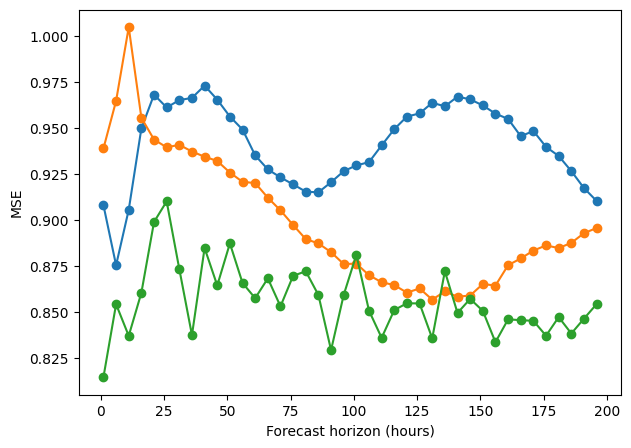

In [30]:
all_scores = {}
for to_forecast in ["non_shiftable_load", "dhw_demand", "cooling_demand"]:
    print(f"FORECASTING: {to_forecast}")
    scores = {}
    for i in range(1, 200, 5):
        print(f"OUT_STEPS: {i}")
        OUT_STEPS = i
        scores[i] = run(OUT_STEPS=i, to_forecast=to_forecast)

    import json

    # write dict to file
    with open("scores.txt", "w") as file:
        file.write(json.dumps(scores))

    all_scores[to_forecast] = scores

plt.figure(figsize=(7, 5))
for to_forecast, scores in all_scores.items():
    plt.plot(list(scores.keys()), list(scores.values()), "-o")
plt.xlabel("Forecast horizon (hours)")
plt.ylabel("MSE")
plt.show()